---
# **Author:** [Ganesh Morye](mailto:ganesh.morye@gmail.com)  
[LinkedIn](https://www.linkedin.com/in/ganeshmorye/) | 
[GitHub](https://github.com/ganeshmorye) |
[Homepage](https://www.ganeshmorye.com/)

---

## Overview


This project aims to leverage data analytics and machine learning techniques to analyze and predict credit card default risk. A financial service company's primary product is a high-value credit card associated with high customer lifetime values (LTVs). The partner is looking to reduce losses from customer defaults by offering a new, lower-value card that supports balance management and helps customers avoid default. By proactively identifying customers at risk of defaulting on credit card payments, the goal is to minimize financial losses and enhance customer relationship management for financial institutions. These customers who are at risk of defaulting on credit card will be offered the new balance management card while keeping the good customers in the high-LTV traditional card.



## Motivation



Predicting credit card default risk is crucial for financial institutions as it helps in mitigating financial risks and understanding customer behavior. This understanding enables the development of tailored financial solutions that foster customer loyalty and trust.


## Imports

In [23]:
# Basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

# Preprocessing tools
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline

# Model selection tools
from sklearn.model_selection import (
    train_test_split, StratifiedKFold,
    cross_val_score, GridSearchCV, RandomizedSearchCV
)

# Machine Learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    GradientBoostingClassifier, VotingClassifier,
    RandomForestClassifier, StackingClassifier
)
from sklearn.cluster import KMeans, DBSCAN

# Metrics for evaluation
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, log_loss, silhouette_score
)
from sklearn.metrics.pairwise import pairwise_distances

# Imbalanced data handling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Hyperparameter optimization
import optuna

# Miscellaneous utilities
from scipy.stats import chi2_contingency
from joblib import dump, load


## Data Overview

The dataset encompasses various aspects of customer information, including:

- **Demographic Information**: Gender, education level, marital status, and age.
- **Credit Information**: Credit limit, indicating the institution's trust in the customer.
- **Payment History**: Detailed records from the past six months, offering insights into the customer's financial reliability.
- **Bill Amounts & Payment Amounts**: Monthly billing statements and actual payments made, shedding light on financial behavior and liquidity.
- **Default Status**: The target variable indicating whether a customer defaulted in October.

In [24]:
def load_data():
    train_data_path = '../data/train.csv'
    test_data_path = '../data/test.csv'
    
    train_df = pd.read_csv(train_data_path)
    test_df = pd.read_csv(test_data_path)

    return train_df, test_df

In [25]:
train_df, test_df = load_data()

In [26]:
print("Training Data:")
train_df.head()


Training Data:


customer_id  limit_bal  sex  education  marriage   age  pay_1  pay_2  \
0            1       1500  2.0        1.0       2.0  23.0    0.0    0.0   
1            2       8500  2.0        2.0       2.0  29.0    0.0    0.0   
2            3       1000  1.0        1.0       2.0  22.0    0.0    0.0   
3            4      10500  1.0        1.0       1.0  31.0    0.0    0.0   
4            5      10500  2.0        2.0       1.0  44.0    0.0    0.0   

   pay_3  pay_4  ...  bill_amt4  bill_amt5  bill_amt6  pay_amt1  pay_amt2  \
0    0.0    2.0  ...       1463      938.0      698.0        75       150   
1    0.0    0.0  ...       8364     8275.0     8425.0       300       400   
2    0.0    0.0  ...        933      772.0      794.0       150       150   
3    0.0    0.0  ...       7190     7229.0     7340.0       255       260   
4    0.0    0.0  ...       3558     3592.0     3496.0       180       155   

   pay_amt3  pay_amt4  pay_amt5  pay_amt6  default_oct  
0        86         0      50.0      50.0          yes  
1       315       300     325.0     305.0           no  
2       150        24     105.0     110.0           no  
3       258       260     265.0     307.0           no  
4       145       130     135.0     200.0           no  

[5 rows x 25 columns]

In [27]:
print("Test Data:")
test_df.head()


Test Data:


customer_id  limit_bal  sex  education  marriage   age  pay_1  pay_2  \
0        24002      10500  1.0        2.0       2.0  34.0    0.0    0.0   
1        24003      27500  2.0        5.0       2.0  52.0   -2.0   -2.0   
2        24004      27500  2.0        2.0       1.0  32.0    2.0    0.0   
3        24005       9000  2.0        2.0       1.0  32.0    1.0    2.0   
4        24006        500  1.0        3.0       2.0  42.0    1.0    2.0   

   pay_3  pay_4  ...  bill_amt3  bill_amt4  bill_amt5  bill_amt6  pay_amt1  \
0    0.0    0.0  ...       2080       1741      881.0      120.0        99   
1   -2.0   -2.0  ...      12816        987       23.0      409.0       300   
2    0.0    0.0  ...      26775      27401    26533.0     7754.0      1054   
3    2.0    2.0  ...        887        858      936.0     1169.0         0   
4    2.0    2.0  ...        431        294      220.0      259.0         0   

   pay_amt2  pay_amt3  pay_amt4  pay_amt5  pay_amt6  
0      1053       724       884     120.0      24.0  
1       300       987        23     409.0       0.0  
2      1143      8381       700     215.0    7903.0  
3       150         0       100     250.0     100.0  
4       129         0        50      50.0      17.0  

[5 rows x 24 columns]

**Data Dictionary for Credit Card Default Dataset**

This data dictionary provides detailed information about each feature in the "Default of Credit Card Clients" dataset.

| Feature Name | Data Type | Description |
|--------------|-----------|-------------|
| `limit_bal`  | Numeric   | The total amount of credit provided to the borrower, including individual and family (supplementary) credit, measured in dollars. |
| `sex`        | Categorical | Gender of the borrower, encoded as `1` for `male` and `2` for `female`. |
| `education`  | Categorical | Education level of the borrower, categorized as `1` for `graduate school`, `2` for `university`, `3` for `high school`, and `4` for `others`. |
| `marriage`   | Categorical | Marital status of the borrower, where `1` denotes `married`, `2` denotes `single`, and `3` denotes `others`. |
| `age`        | Numeric   | Age of the borrower, measured in `years`. |
| `pay_1` - `pay_6` | Ordered Categorical | Repayment status of the borrower over the last six months, from April (pay_6) to September (pay_1). A scale of `-1` indicates payment was made `duly`; `1 to 9` indicates payment `delays` of `one month to nine months` or more, respectively. |
| `bill_amt1` - `bill_amt6` | Numeric | Amount of `bill statement` for the borrower, in `dollars`, for the last six months, from `April (bill_amt6) to September (bill_amt1)`. |
| `pay_amt1` - `pay_amt6` | Numeric | Amount of `previous payment` made by the borrower, in dollars, for the last six months, from `April (pay_amt6) to September (pay_amt1)`. |
| `default_oct` | Binary Categorical | Indicates whether the borrower `defaulted` in `October`, with `'yes'` for default and `'no'` for non-default. |


In [28]:

print("\nSummary Statistics for Training Data:")
train_df.describe().T



Summary Statistics for Training Data:


count          mean          std      min     25%      50%  \
customer_id  24001.0  12001.000000  6928.636241      1.0  6001.0  12001.0   
limit_bal    24001.0   8351.302029  6475.592450    500.0  2500.0   7000.0   
sex          24001.0      1.604058     0.489062      1.0     1.0      2.0   
education    24001.0      1.856839     0.792152      0.0     1.0      2.0   
marriage     24001.0      1.551644     0.522663      0.0     1.0      2.0   
age          24001.0     35.498438     9.222021     21.0    28.0     34.0   
pay_1        24001.0     -0.015874     1.123554     -2.0    -1.0      0.0   
pay_2        24001.0     -0.132119     1.199237     -2.0    -1.0      0.0   
pay_3        24001.0     -0.166201     1.196802     -2.0    -1.0      0.0   
pay_4        24001.0     -0.215824     1.173350     -2.0    -1.0      0.0   
pay_5        23819.0     -0.263403     1.135120     -2.0    -1.0      0.0   
pay_6        22790.0     -0.286529     1.152145     -2.0    -1.0      0.0   
bill_amt1    24001.0   2574.245865  3706.812804  -8279.0   177.0   1123.0   
bill_amt2    24001.0   2467.107037  3585.952168  -3488.0   147.0   1059.0   
bill_amt3    24001.0   2359.795592  3499.639871  -3075.0   130.0   1007.0   
bill_amt4    24001.0   2175.804383  3244.170936  -8500.0   116.0    953.0   
bill_amt5    23819.0   2024.383559  3063.487512  -4066.0    90.0    906.0   
bill_amt6    22790.0   1960.335981  3015.469078 -10452.0    62.0    855.5   
pay_amt1     24001.0    281.079955   846.819525      0.0    49.0    105.0   
pay_amt2     24001.0    298.237073  1215.481369      0.0    41.0    100.0   
pay_amt3     24001.0    263.109704   899.406651      0.0    19.0     90.0   
pay_amt4     24001.0    243.367943   782.138847      0.0    15.0     75.0   
pay_amt5     23819.0    238.731139   779.341974      0.0    12.0     75.0   
pay_amt6     22790.0    256.517069   861.106314      0.0     6.0     75.0   

                 75%      max  
customer_id  18001.0  24001.0  
limit_bal    12000.0  50000.0  
sex              2.0      2.0  
education        2.0      6.0  
marriage         2.0      3.0  
age             41.0     79.0  
pay_1            0.0      8.0  
pay_2            0.0      8.0  
pay_3            0.0      8.0  
pay_4            0.0      8.0  
pay_5            0.0      8.0  
pay_6            0.0      8.0  
bill_amt1     3375.0  48225.0  
bill_amt2     3202.0  49196.0  
bill_amt3     3015.0  83204.0  
bill_amt4     2752.0  44579.0  
bill_amt5     2510.5  46358.0  
bill_amt6     2466.0  48083.0  
pay_amt1       250.0  43677.0  
pay_amt2       250.0  84212.0  
pay_amt3       227.0  44802.0  
pay_amt4       200.0  31050.0  
pay_amt5       200.0  21326.0  
pay_amt6       200.0  26433.0

**Observations**

**Customer ID**: This appears to be a unique identifier for each customer, ranging from 1 to 24,001. It's evenly distributed, which is expected for an ID field.

**Limit Balance (limit_bal)**: The average credit limit is around 8,351 with a wide range from 500 to 50,000. This suggests variability in the creditworthiness of the customers.

**Sex**: It's a binary variable where presumably 1 stands for male and 2 stands for female. The mean is closer to 2, suggesting there are more females than males in the dataset.

**Education**: Ranges from 0 to 6, despite the documentation mentioning categories only from 1 to 4. The extra categories (0, 5, 6) might need clarification or could be treated as missing or 'other' categories.

**Marriage**: Also has unexpected values (0), since documentation mentions 1 to 3. Like education, these need clarification or reclassification.

**Age**: Customers range from 21 to 79 years old, with an average age of around 35. This suggests a predominantly young to middle-aged customer base.

**Payment Status (pay_1 to pay_6)**: These fields show the repayment status over the last six months. They have values from -2 to 8, where negative values should theoretically represent timely payments or pay duly, and positive values indicate months of delay. The presence of -2 needs to be clarified as it's not described in the documentation provided.

**Bill Amounts (bill_amt1 to bill_amt6)**: These vary widely and can be negative, which might indicate credits or reversals. They show the amount of bill statement over the last six months.

**Payment Amounts (pay_amt1 to pay_amt6)**: These show the amount paid by the customer in the past six months. The amounts vary significantly, with the maximum payments in some months being quite high compared to the averages, indicating some outliers or very high payments.

**Missing Values**: There are missing values in the payment status fields for the later months (pay_5, pay_6) and corresponding bill and payment amounts (bill_amt5, bill_amt6, pay_amt5, pay_amt6). 

In [29]:
print("\nSummary Statistics for Test Data:")
test_df.describe().T



Summary Statistics for Test Data:


count          mean          std      min      25%      50%  \
customer_id  5999.0  27001.000000  1731.906464  24002.0  25501.5  27001.0   
limit_bal    5999.0   8465.891649  6534.081379    500.0   2500.0   7000.0   
sex          5999.0      1.602434     0.489436      1.0      1.0      2.0   
education    5999.0      1.838306     0.782984      0.0      1.0      2.0   
marriage     5999.0      1.552759     0.519229      0.0      1.0      2.0   
age          5999.0     35.433739     9.201999     21.0     28.0     34.0   
pay_1        5999.0     -0.020003     1.124880     -2.0     -1.0      0.0   
pay_2        5999.0     -0.140357     1.189023     -2.0     -1.0      0.0   
pay_3        5999.0     -0.166194     1.197231     -2.0     -1.0      0.0   
pay_4        5999.0     -0.240040     1.152027     -2.0     -1.0      0.0   
pay_5        5955.0     -0.281444     1.126996     -2.0     -1.0      0.0   
pay_6        5709.0     -0.310913     1.147430     -2.0     -1.0      0.0   
bill_amt1    5999.0   2506.752292  3579.547514   -490.0    179.0   1097.0   
bill_amt2    5999.0   2424.308218  3447.314755  -1500.0    156.0   1065.0   
bill_amt3    5999.0   2312.106184  3335.419806  -7863.0    139.0    991.0   
bill_amt4    5999.0   2110.538923  3103.495178  -1374.0    116.0    949.0   
bill_amt5    5955.0   1971.674559  2950.030089  -1807.0     76.0    894.0   
bill_amt6    5709.0   1904.727973  2865.255691 -16980.0     63.0    835.0   
pay_amt1     5999.0    290.436906   748.761295      0.0     50.0    106.0   
pay_amt2     5999.0    286.199700   852.091851      0.0     41.5    100.0   
pay_amt3     5999.0    252.901984   799.425171      0.0     20.0     90.0   
pay_amt4     5999.0    232.027005   787.833885      0.0     11.0     75.0   
pay_amt5     5955.0    242.401175   698.798315      0.0     10.5     77.0   
pay_amt6     5709.0    284.189525  1031.312882      0.0      3.0     75.0   

                 75%      max  
customer_id  28500.5  30000.0  
limit_bal    12000.0  40000.0  
sex              2.0      2.0  
education        2.0      6.0  
marriage         2.0      3.0  
age             41.0     75.0  
pay_1            0.0      8.0  
pay_2            0.0      7.0  
pay_3            0.0      7.0  
pay_4            0.0      7.0  
pay_5            0.0      7.0  
pay_6            0.0      8.0  
bill_amt1     3282.0  31087.0  
bill_amt2     3185.5  28478.0  
bill_amt3     2971.0  28897.0  
bill_amt4     2601.0  30841.0  
bill_amt5     2489.0  27394.0  
bill_amt6     2455.0  24955.0  
pay_amt1       255.5  15240.0  
pay_amt2       250.0  16273.0  
pay_amt3       220.0  20879.0  
pay_amt4       200.0  26444.0  
pay_amt5       209.0  16549.0  
pay_amt6       200.0  26357.0

Customer ID: The IDs range from 24,002 to 30,000, which doesn't overlap with the training data. This is expected since these should be unique identifiers for different sets of customers.

Limit Balance (limit_bal): Similar to the training set, there’s a wide range in credit limits, from 500 to 40,000. The average limit balance is slightly higher than in the training set but within a similar range, indicating consistency between the two datasets.

Sex, Education, Marriage: The distributions of these categorical variables are similar to those in the training data. Like the training data, there are unexpected values in 'education' and 'marriage' categories, indicating that these anomalies are consistent across both datasets.

Age: The age distribution is also similar, with a predominantly young to middle-aged customer base.

Payment Status (pay_1 to pay_6): The trends are consistent with the training data, showing the repayment status over the last six months. Negative values, which are not clearly defined in the documentation, seem to indicate non-delayed payments.

Bill Amounts (bill_amt1 to bill_amt6): The amounts range widely, and some are negative, which could indicate credits or corrections. These figures are consistent with what we saw in the training set, indicating typical billing patterns.

Payment Amounts (pay_amt1 to pay_amt6): There are wide variations in payment amounts, with some high outliers, similar to the training dataset.

Missing Values: Like in the training set, there are missing values in the later payment status fields (pay_5 and pay_6) and corresponding bill and payment amounts. 

## Exploratory Data Analysis

### Missing Values Investigation

In [9]:


print("Missing Values in Training Data:")
missing_values_train = train_df.isnull().sum()
print(missing_values_train[missing_values_train > 0])

print("\nMissing Values in Test Data:")
missing_values_test = test_df.isnull().sum()
print(missing_values_test[missing_values_test > 0])



Missing Values in Training Data:
pay_5         182
pay_6        1211
bill_amt5     182
bill_amt6    1211
pay_amt5      182
pay_amt6     1211
dtype: int64

Missing Values in Test Data:
pay_5         44
pay_6        290
bill_amt5     44
bill_amt6    290
pay_amt5      44
pay_amt6     290
dtype: int64


In [10]:
# Filter rows with missing values for pay_5, bill_amt5, and pay_amt5
missing_pay_5 = train_df[train_df['pay_5'].isnull()]

# Examine other attributes of these rows
print("Statistics for rows missing pay_5, bill_amt5, and pay_amt5:\n")
missing_pay_5.describe().T


Statistics for rows missing pay_5, bill_amt5, and pay_amt5:



count          mean          std    min      25%      50%  \
customer_id  182.0  12160.890110  6943.042546   11.0  6323.75  11843.5   
limit_bal    182.0   8434.065934  6710.966037  500.0  2625.00   7000.0   
sex          182.0      1.609890     0.489120    1.0     1.00      2.0   
education    182.0      1.851648     0.709036    1.0     1.00      2.0   
marriage     182.0      1.532967     0.532389    0.0     1.00      2.0   
age          182.0     35.120879     9.109324   22.0    28.00     34.0   
pay_1        182.0      0.060440     1.142681   -2.0    -1.00      0.0   
pay_2        182.0      0.065934     1.215027   -2.0    -1.00      0.0   
pay_3        182.0     -0.027473     1.218782   -2.0    -1.00      0.0   
pay_4        182.0     -0.038462     1.162800   -2.0    -1.00      0.0   
pay_5          0.0           NaN          NaN    NaN      NaN      NaN   
pay_6          0.0           NaN          NaN    NaN      NaN      NaN   
bill_amt1    182.0   3094.340659  4124.654108  -51.0   377.00   1473.0   
bill_amt2    182.0   3029.818681  4154.886589    0.0   218.00   1386.0   
bill_amt3    182.0   2711.274725  3692.585965 -596.0   345.00   1252.0   
bill_amt4    182.0   2443.296703  3222.208635  -56.0   232.25   1180.0   
bill_amt5      0.0           NaN          NaN    NaN      NaN      NaN   
bill_amt6      0.0           NaN          NaN    NaN      NaN      NaN   
pay_amt1     182.0    285.620879   812.253896    0.0    64.00    147.0   
pay_amt2     182.0    266.675824   652.153381    0.0    50.00    105.0   
pay_amt3     182.0    255.549451   554.377063    0.0    34.00    100.0   
pay_amt4     182.0    304.571429   984.483263    0.0    16.50     75.0   
pay_amt5       0.0           NaN          NaN    NaN      NaN      NaN   
pay_amt6       0.0           NaN          NaN    NaN      NaN      NaN   

                  75%      max  
customer_id  18020.50  24001.0  
limit_bal    12500.00  26000.0  
sex              2.00      2.0  
education        2.00      5.0  
marriage         2.00      3.0  
age             40.00     62.0  
pay_1            0.00      4.0  
pay_2            0.00      5.0  
pay_3            0.00      4.0  
pay_4            0.00      4.0  
pay_5             NaN      NaN  
pay_6             NaN      NaN  
bill_amt1     4084.00  21722.0  
bill_amt2     4054.00  22181.0  
bill_amt3     3871.25  22636.0  
bill_amt4     3256.75  15662.0  
bill_amt5         NaN      NaN  
bill_amt6         NaN      NaN  
pay_amt1       300.00  10350.0  
pay_amt2       269.00   7828.0  
pay_amt3       245.25   4323.0  
pay_amt4       250.00  11612.0  
pay_amt5          NaN      NaN  
pay_amt6          NaN      NaN

In [11]:

missing_pay_6 = train_df[train_df['pay_6'].isnull()]
print("Statistics for rows missing pay_6, bill_amt6, and pay_amt6:\n")
missing_pay_6.describe().T


Statistics for rows missing pay_6, bill_amt6, and pay_amt6:



count          mean          std    min     25%      50%  \
customer_id  1211.0  12161.930636  6830.666852   11.0  6225.0  12371.0   
limit_bal    1211.0   8157.308010  6427.425922  500.0  2500.0   7000.0   
sex          1211.0      1.587944     0.492408    1.0     1.0      2.0   
education    1211.0      1.850537     0.747418    1.0     1.0      2.0   
marriage     1211.0      1.545830     0.527121    0.0     1.0      2.0   
age          1211.0     35.688687     9.305185   21.0    28.0     34.0   
pay_1        1211.0     -0.001652     1.142708   -2.0    -1.0      0.0   
pay_2        1211.0     -0.124690     1.199921   -2.0    -1.0      0.0   
pay_3        1211.0     -0.174236     1.176293   -2.0    -1.0      0.0   
pay_4        1211.0     -0.199835     1.157669   -2.0    -1.0      0.0   
pay_5        1029.0     -0.292517     1.097819   -2.0    -1.0      0.0   
pay_6           0.0           NaN          NaN    NaN     NaN      NaN   
bill_amt1    1211.0   2602.285714  3702.510815 -104.0   163.5   1187.0   
bill_amt2    1211.0   2505.438481  3626.711301 -132.0   150.5   1051.0   
bill_amt3    1211.0   2298.639141  3378.745520 -596.0   145.0    991.0   
bill_amt4    1211.0   2086.767960  3144.013947  -97.0   116.5    942.0   
bill_amt5    1029.0   1878.174927  2992.292529 -316.0    85.0    835.0   
bill_amt6       0.0           NaN          NaN    NaN     NaN      NaN   
pay_amt1     1211.0    273.542527   704.881336    0.0    50.0    110.0   
pay_amt2     1211.0    235.216350   528.067091    0.0    41.0    100.0   
pay_amt3     1211.0    235.175888   712.377045    0.0    19.0     83.0   
pay_amt4     1211.0    237.672998   737.161785    0.0    16.5     73.0   
pay_amt5     1029.0    202.112731   553.311391    0.0    15.0     65.0   
pay_amt6        0.0           NaN          NaN    NaN     NaN      NaN   

                 75%      max  
customer_id  17951.5  24001.0  
limit_bal    12000.0  32500.0  
sex              2.0      2.0  
education        2.0      6.0  
marriage         2.0      3.0  
age             42.0     79.0  
pay_1            0.0      8.0  
pay_2            0.0      7.0  
pay_3            0.0      6.0  
pay_4            0.0      7.0  
pay_5            0.0      7.0  
pay_6            NaN      NaN  
bill_amt1     3390.5  25074.0  
bill_amt2     3261.0  25523.0  
bill_amt3     2939.0  26024.0  
bill_amt4     2670.5  26287.0  
bill_amt5     2335.0  24036.0  
bill_amt6        NaN      NaN  
pay_amt1       250.0  10350.0  
pay_amt2       244.0   7828.0  
pay_amt3       209.5  16919.0  
pay_amt4       200.0  11612.0  
pay_amt5       184.0  10000.0  
pay_amt6         NaN      NaN

In [14]:

plotly_blue = '#636EFA'
plotly_green = '#00CC96'
plotly_red = '#FF5733'

In [12]:
# Variables to compare, divided into numerical and categorical
numerical_columns = ['limit_bal', 'age', 'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4']
categorical_columns = ['sex', 'education', 'marriage', 'pay_1', 'pay_2', 'pay_3', 'pay_4', 'default_oct']

In [13]:


def plot_columns(df, cols, missing_columns, plot_type, figsize=(20, 16), rows=6, cols_per_row=5):
    """
    Plot numerical or categorical columns to compare the distribution of missing vs non-missing data.

    Parameters:
        df (DataFrame): The DataFrame containing the data to plot.
        cols (list): A list of column names to plot.
        missing_columns (list): A list of column names indicating which columns have missing values.
        plot_type (str): The type of plot to create, either 'numerical' or 'categorical'.
        figsize (tuple): The size of the figure, default is (20, 16).
        rows (int): The number of rows in the subplot grid, default is 6.
        cols_per_row (int): The number of columns per row in the subplot grid, default is 5.

    Returns:
        None
    """
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(nrows=rows, ncols=cols_per_row, height_ratios=[0.1, 1, 1, 0.1, 1, 1])

    for i, missing_column in enumerate(missing_columns, start=0):
        ax = fig.add_subplot(gs[3 * i, :])  # Title row
        ax.text(0.5, -0.5, f'{missing_column}', fontsize=16, ha='center')  
        ax.axis('off')  

        for j, var in enumerate(cols, start=0):
            row_index = 3 * i + 1 + (j // cols_per_row)
            col_index = j % cols_per_row
            ax = fig.add_subplot(gs[row_index, col_index])

            if plot_type == 'numerical':
                sns.kdeplot(df[df[missing_column].notnull()][var], ax=ax, label=f'Not Missing {missing_column}', fill=True, color=plotly_blue)
                sns.kdeplot(df[df[missing_column].isnull()][var], ax=ax, label=f'Missing {missing_column}', fill=True, color=plotly_red)
            elif plot_type == 'categorical':
                sns.countplot(x=var, data=df[df[missing_column].notnull()], ax=ax, label='Not Missing', color=plotly_blue)
                sns.countplot(x=var, data=df[df[missing_column].isnull()], ax=ax, label='Missing', color=plotly_red)


            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.set_title(f'{var}')
            ax.legend('')

    if plot_type == 'numerical':
        fig.suptitle('Comparison of Density Distribution of Numerical Variables for Missing vs Non-Missing Data', fontsize=20, fontweight='bold')
    elif plot_type == 'categorical':
        fig.suptitle('Comparison of Counts of Categorical Variables for Missing vs Non-Missing Data', fontsize=20, fontweight='bold')

    plt.tight_layout()


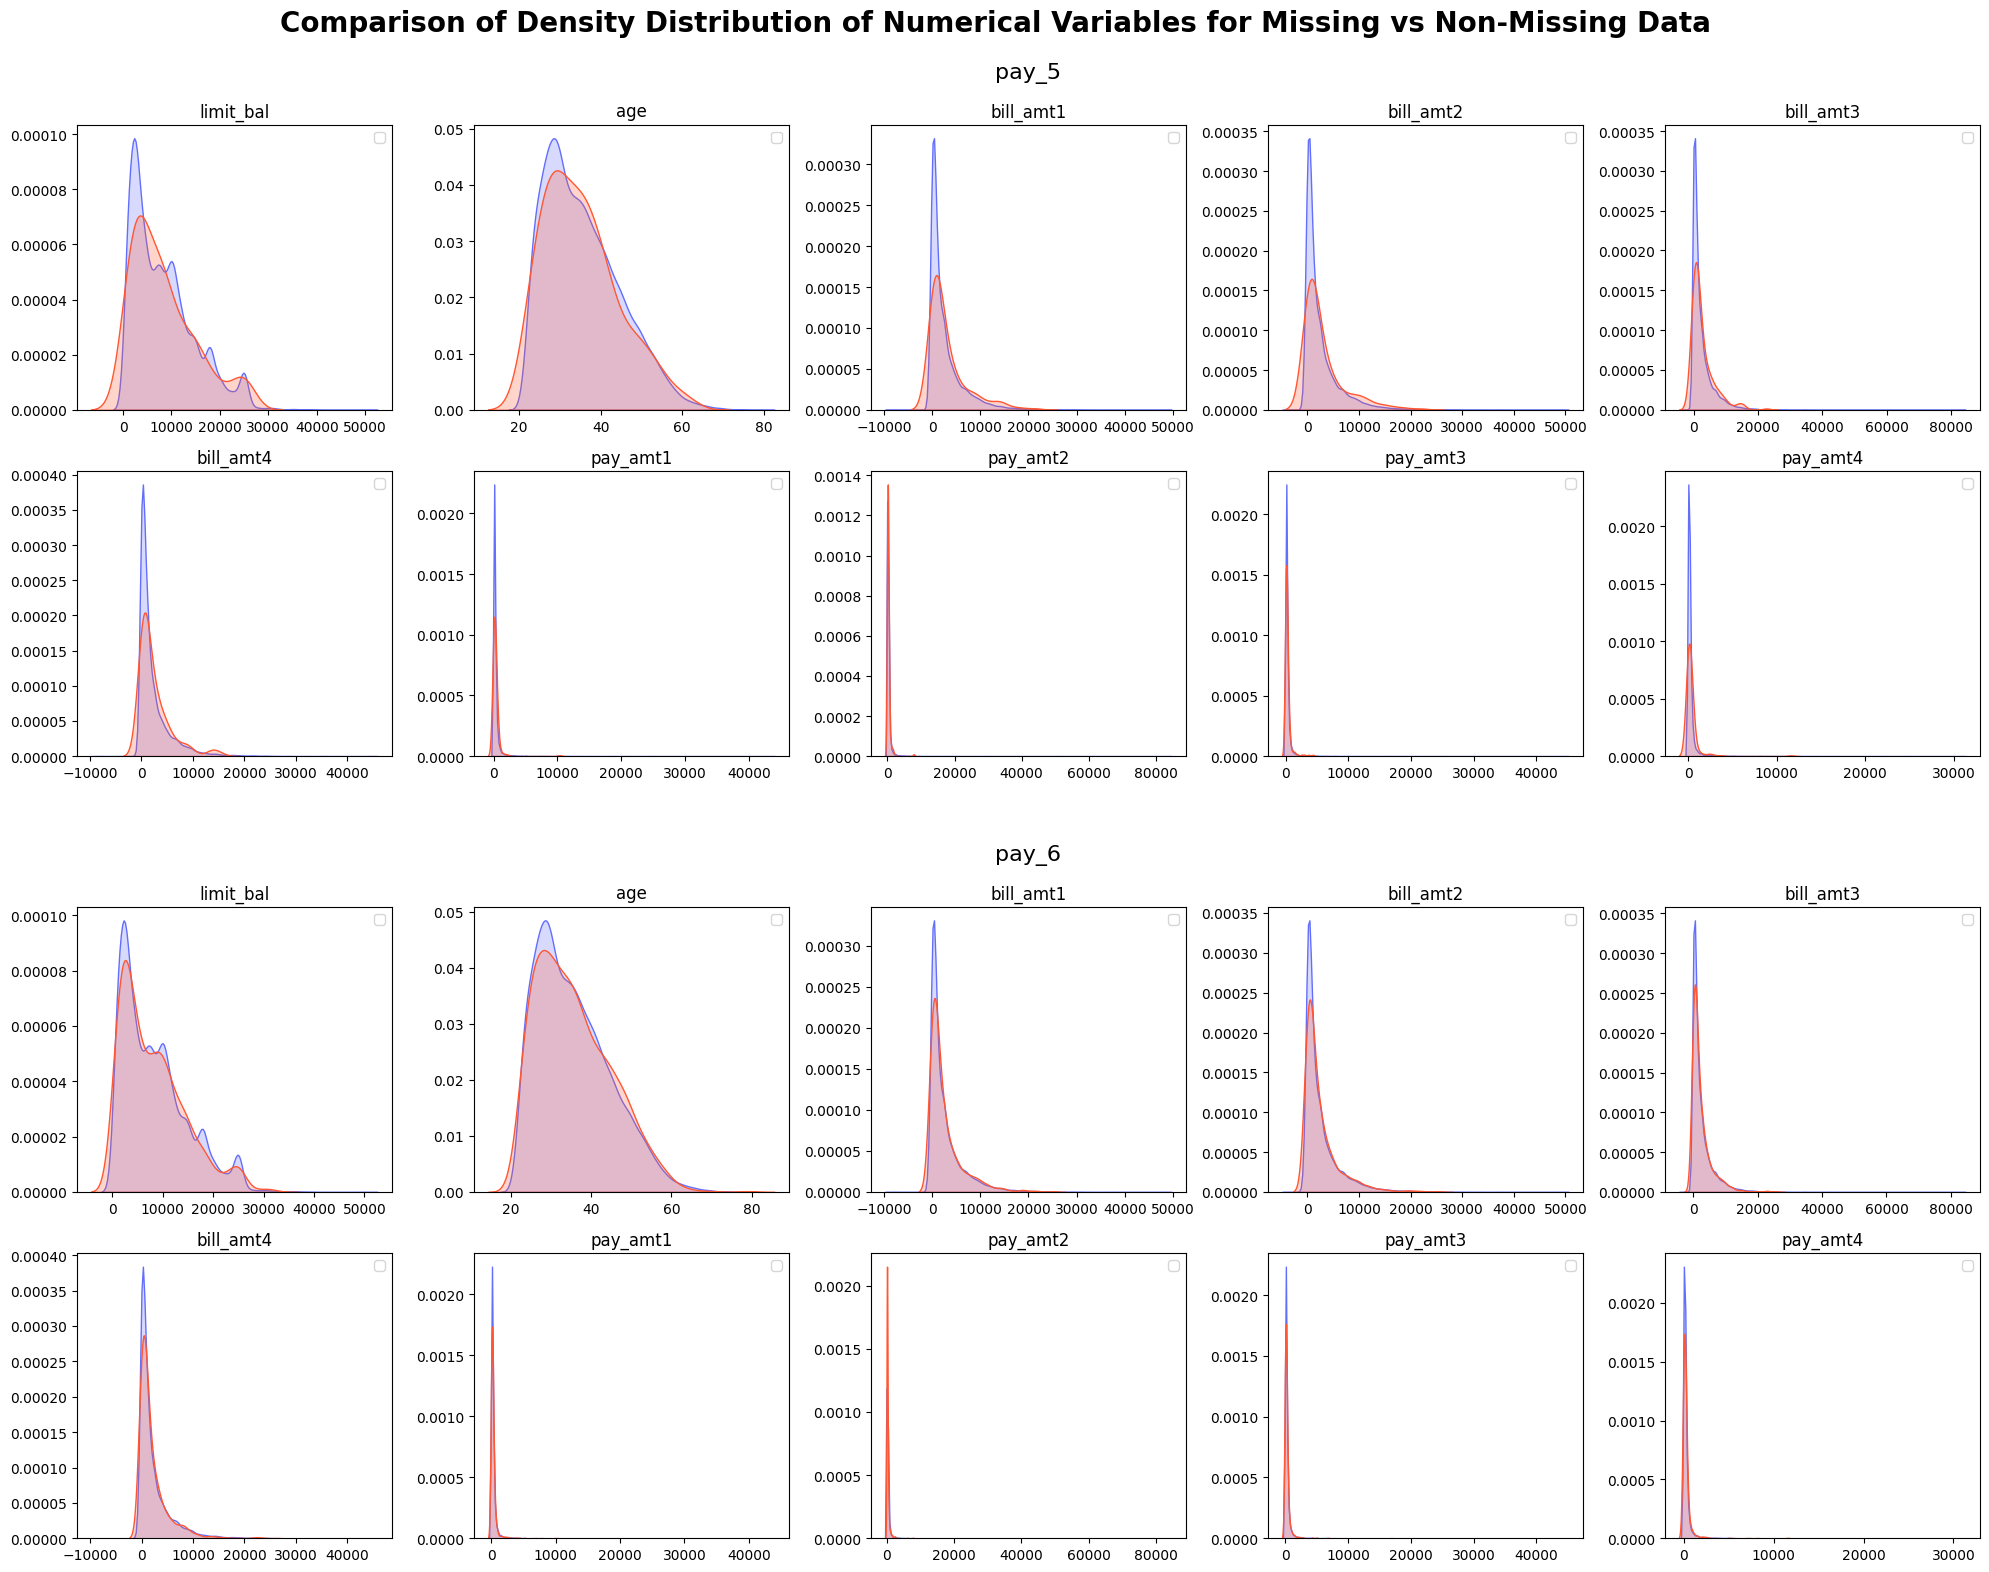

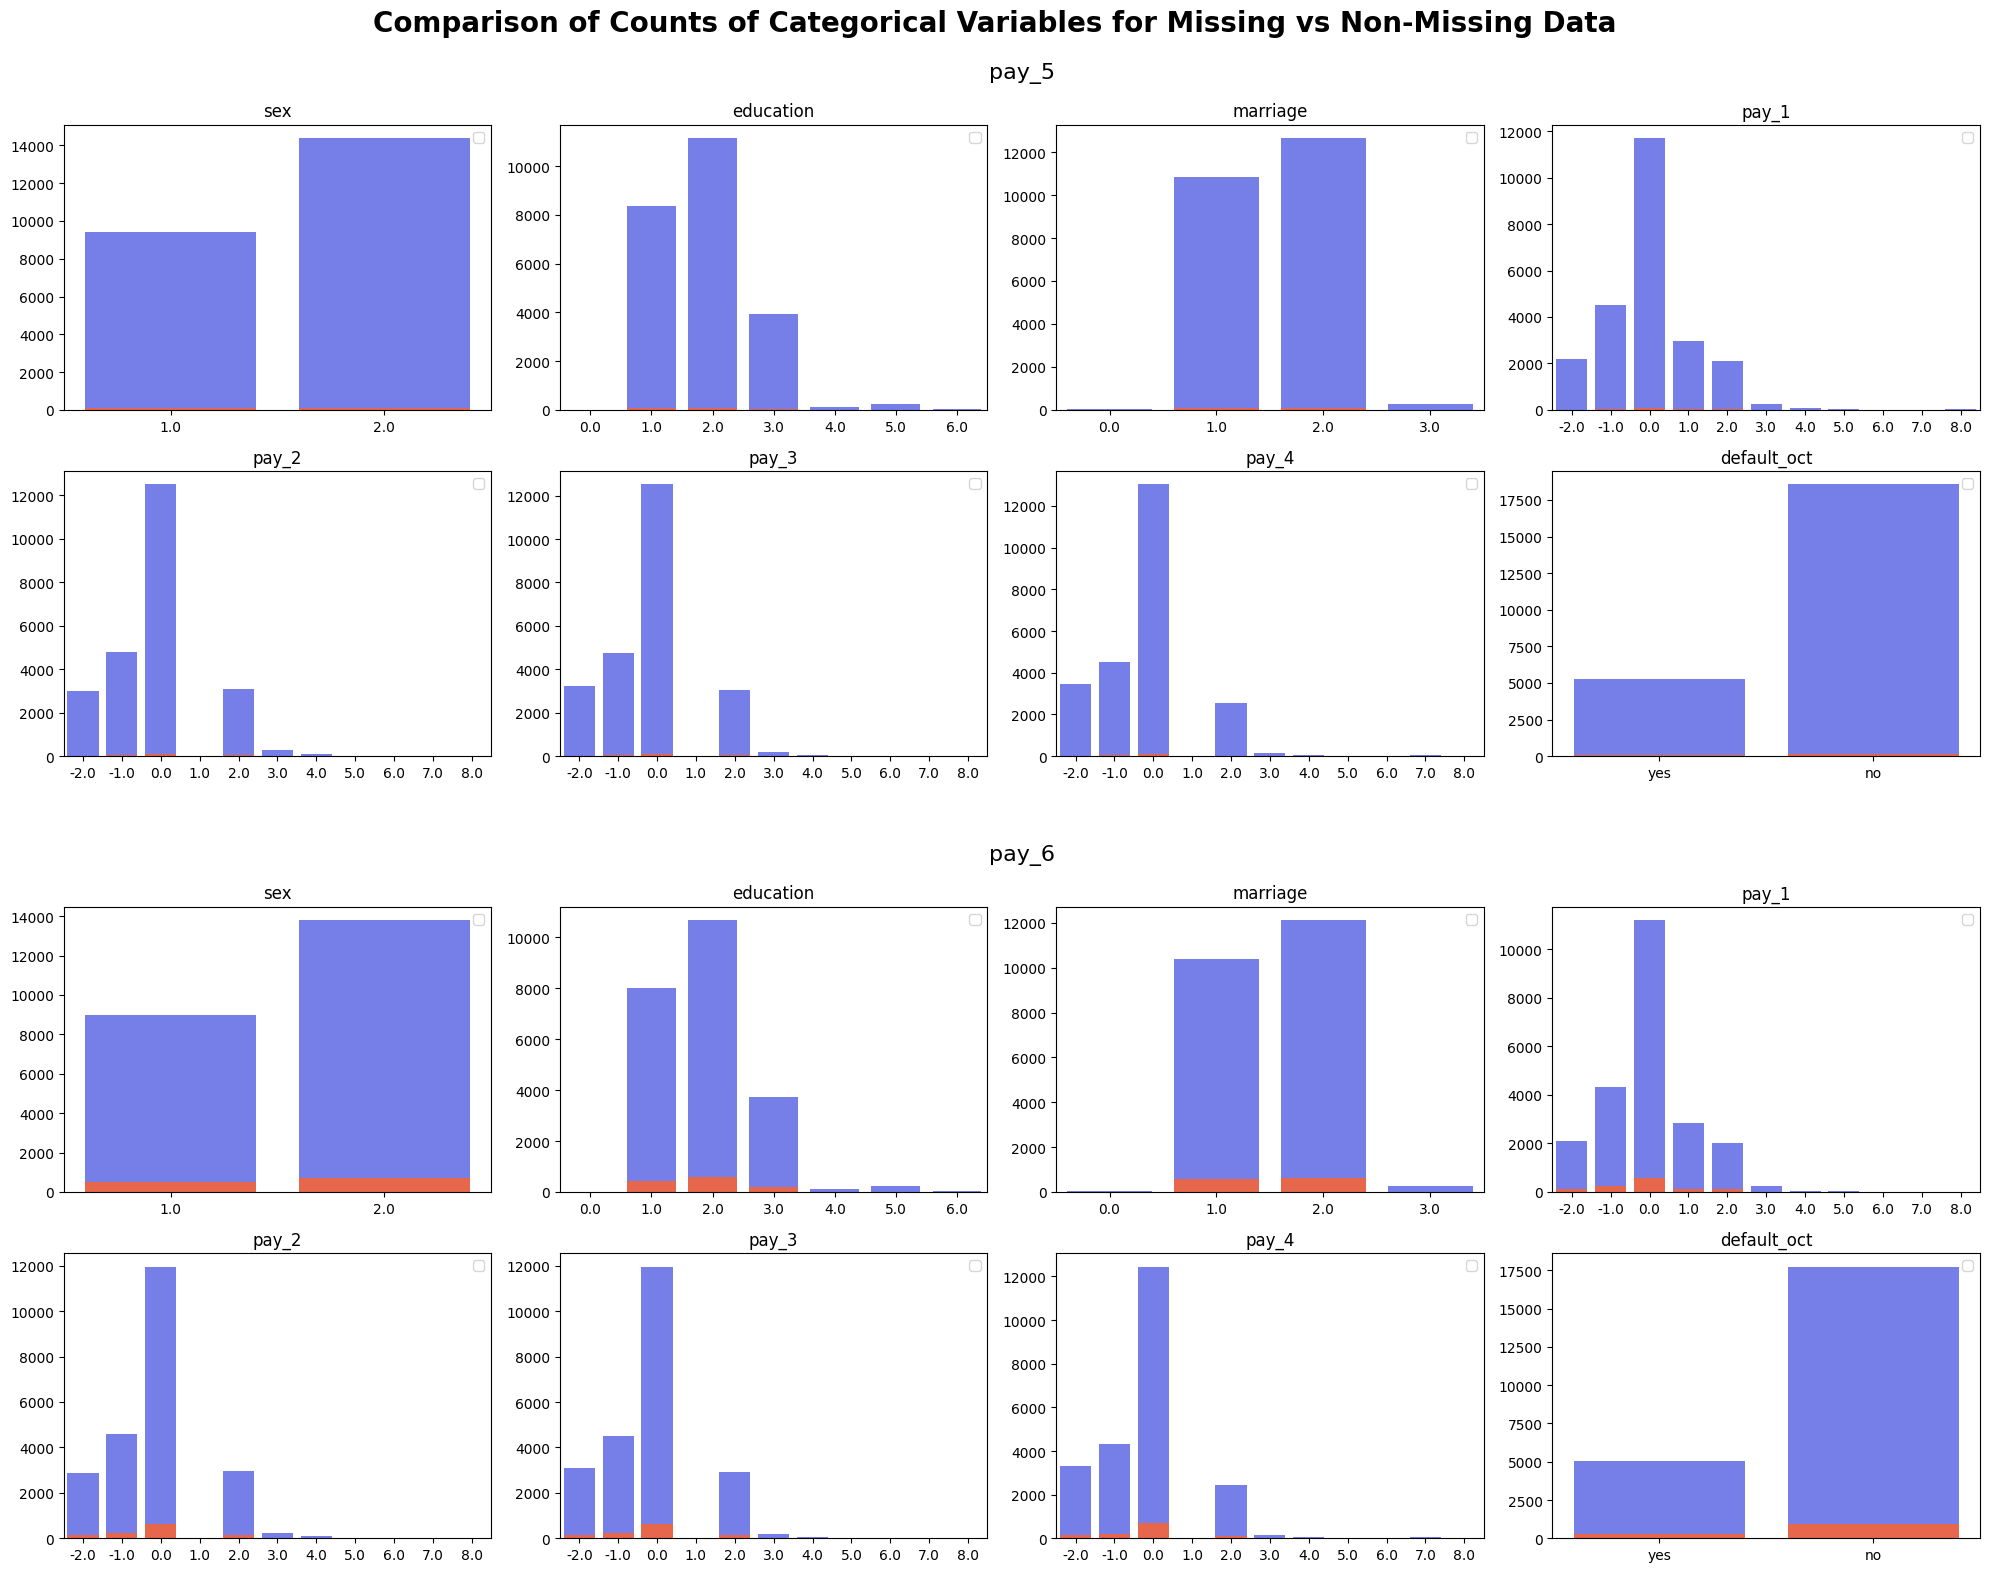

In [14]:
plot_columns(train_df, numerical_columns, ['pay_5', 'pay_6'], 'numerical', cols_per_row=5)
plot_columns(train_df, categorical_columns, ['pay_5', 'pay_6'], 'categorical', cols_per_row=4)

**Analysis of Missing Values in Payment History**

**Findings**:

Our exploratory data analysis focused on the missing values in the `pay_5` and `pay_6` columns, which represent the payment status in the last two months of the dataset. We extended the analysis to associated bill and payment amount variables (`bill_amt5`, `bill_amt6`, `pay_amt5`, `pay_amt6`) to understand the nature of these missing values better.

1. **Distribution Similarity**: The distribution of both numerical and categorical variables remains consistent when comparing rows with missing and non-missing values for `pay_5` and `pay_6`. This pattern suggests that the missingness in these columns is likely Missing Completely at Random (MCAR).

2. **Implications**: Since the missing values appear to be MCAR, they likely do not depend on other variables in the dataset. This suggests that the missing data points might be the result of random errors or omissions during data collection or entry.

**Way Forward**:

Given the nature of the missing values, here's our approach to handling them:

1. **Imputation for Numerical Variables**: For `bill_amt5`, `bill_amt6`, `pay_amt5`, and `pay_amt6`, we can impute missing values using the median of each column. The median is preferred over the mean as it is less sensitive to outliers.


2. **Imputation for Categorical Variables**: For `pay_5` and `pay_6`, we need to decide based on domain knowledge. 

### Outliers Investigation

**Outliers**

Following columns have outliers in the dataset:

pay_1:pay_6 - Valid values are -1 and above. We have a minimum value of -2
education - Valid values are 1-4 but we have a minimum value of 0 and maximal value of 6
marriage - valid values are 1-3 whereas we have a minimum value of 0

Since these values are associated with categorical columns, we will keep these values as-is treating them as a separate category for that feature.

### Data Visualization

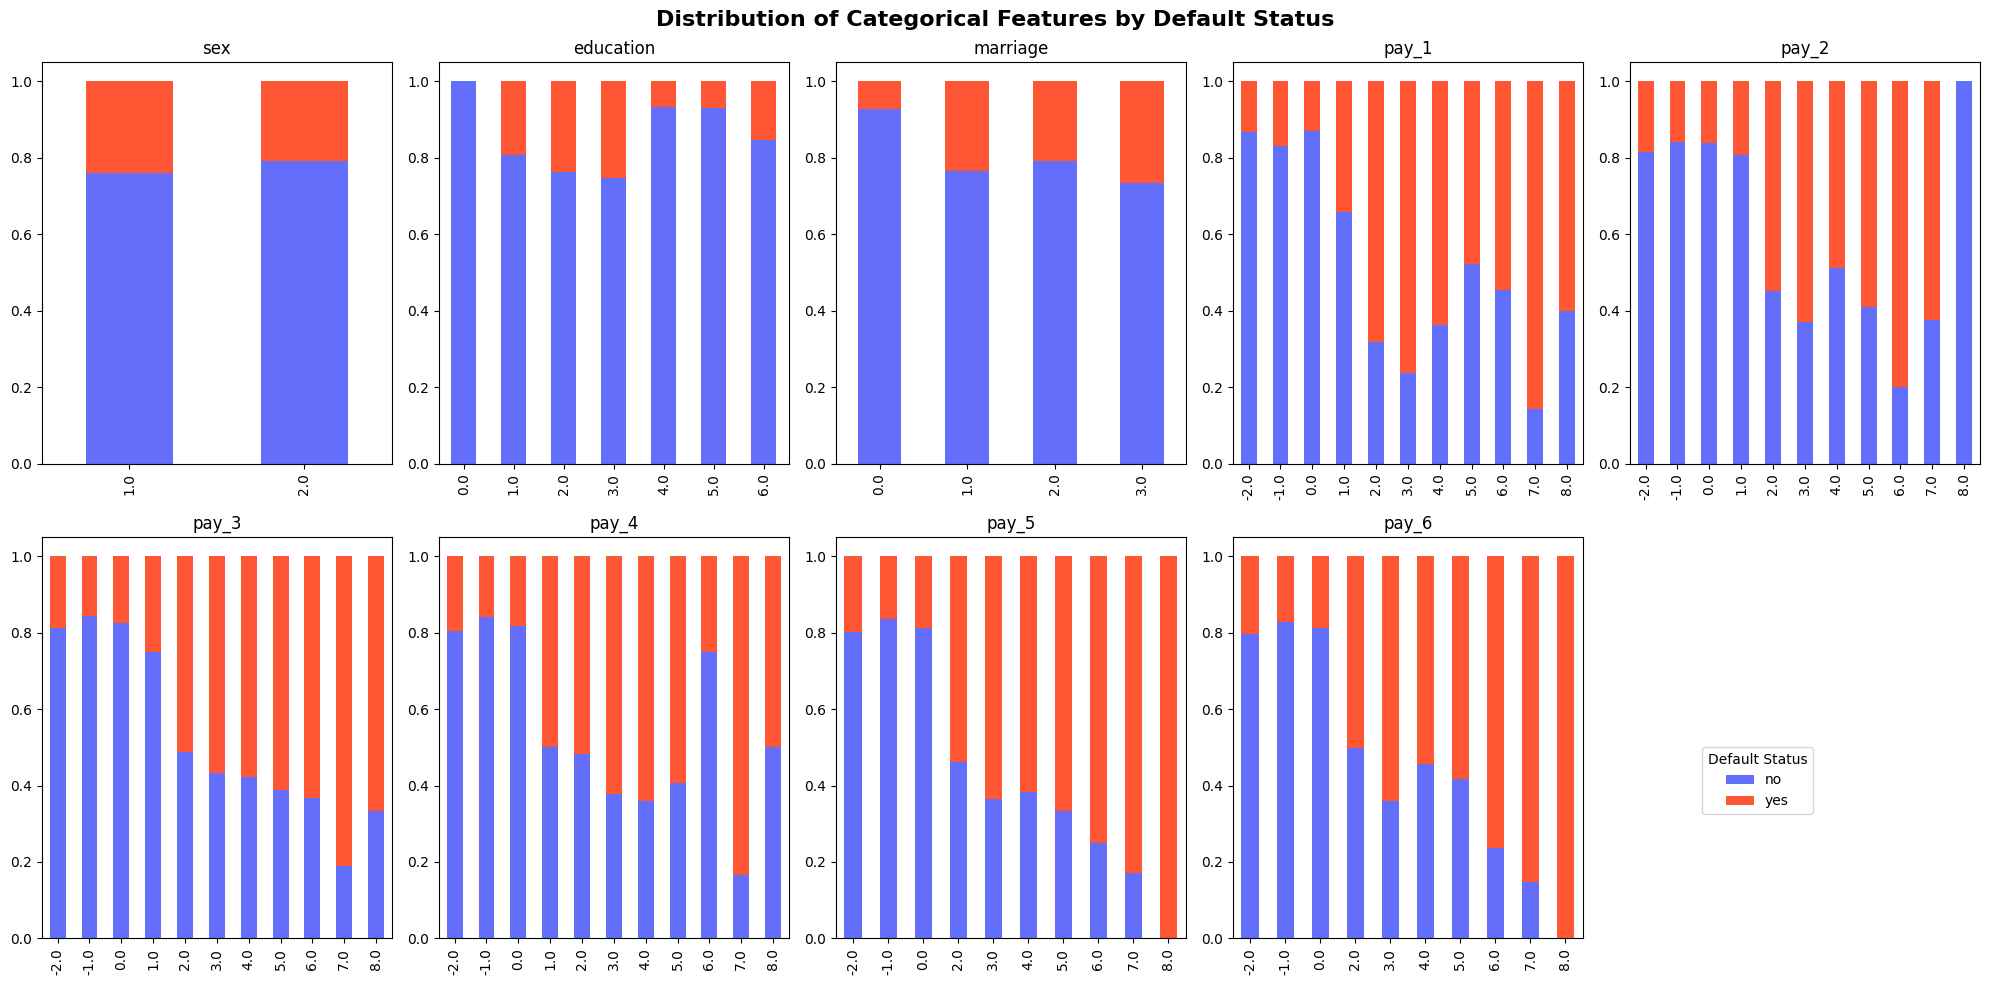

In [15]:
categorical_columns = ['sex', 'education', 'marriage', 'pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'default_oct']


fig = plt.figure(figsize=(20, 10))
gs = GridSpec(2, 5, figure=fig)

# Loop through the categorical variables (excluding the target variable at the end)
for index, feature in enumerate(categorical_columns[:-1]):  
    ax = fig.add_subplot(gs[index // 5, index % 5])
    cross_tab = pd.crosstab(train_df[feature], train_df['default_oct'], normalize='index')
    cross_tab.plot(kind='bar', stacked=True, color=[plotly_blue, plotly_red], ax=ax)
    ax.set_title(feature)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.legend().set_visible(False)  

# Adjust layout and add a single legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.85, 0.25), title='Default Status')
fig.suptitle('Distribution of Categorical Features by Default Status', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

**Observations**

1. `Gender`: The count of default status for both the genders are very similar.
2. `Education`: Amongst the identified categories of education, graduate level customers have slightly lower default status as compared to university and high school customers. The unidentified categories 0, 5, 6 and the `others` category have even lower default status.
3. `Marriage`: Marriage status seems to not significantly influence the default status.
4. `pay_`: The distribution fo counts is very similar for -2 to 7 categories for the pay columns for all previous months. 

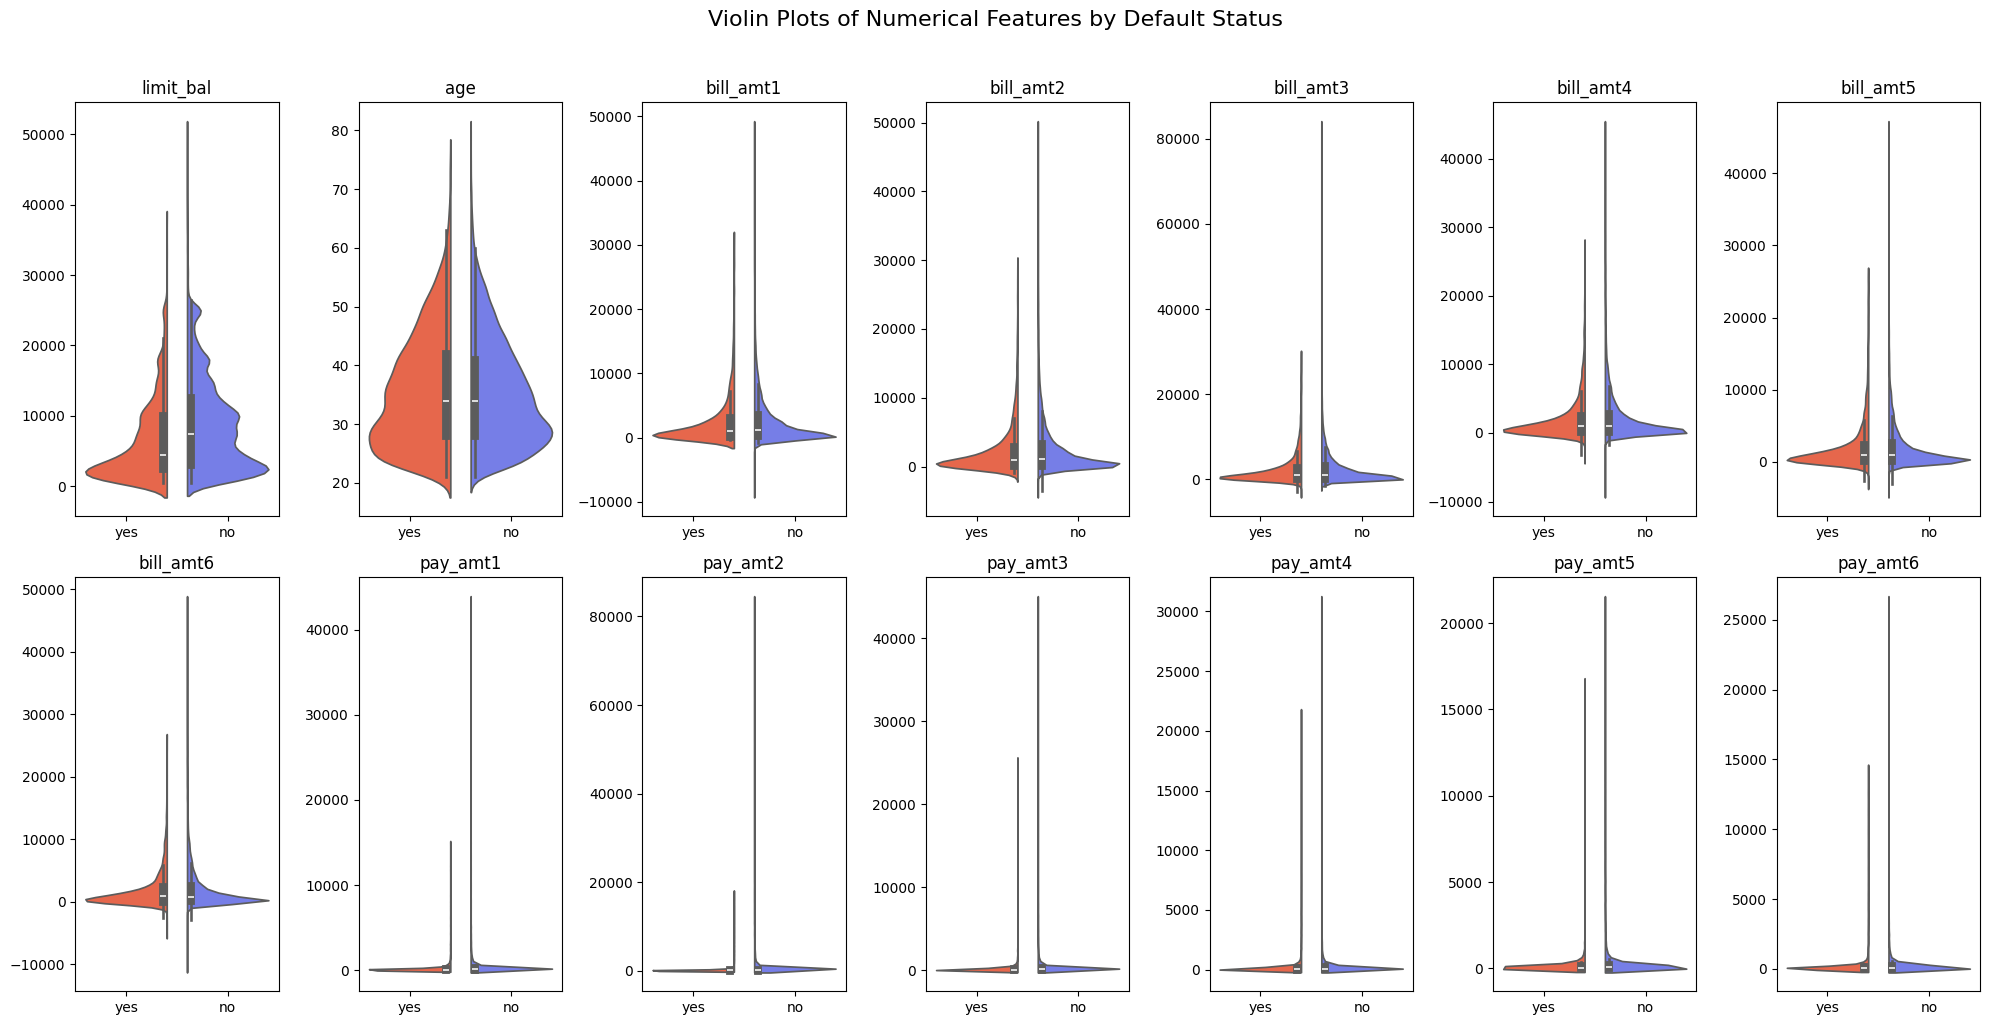

In [22]:
numerical_columns = ['limit_bal', 'age', 'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 
                     'bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']

num_columns = 7
num_rows = len(numerical_columns) // num_columns + (len(numerical_columns) % num_columns > 0)

fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 10))  
fig.suptitle('Violin Plots of Numerical Features by Default Status', fontsize=16, y=1.02)

if num_rows > 1:
    axes = axes.flatten()
else:
    axes = [axes] 

for i, col in enumerate(numerical_columns):
    sns.violinplot(x='default_oct', y=col, data=train_df, hue='default_oct', split=True, ax=axes[i],
                   palette={'no': plotly_blue, 'yes': plotly_red}, legend=False)
    axes[i].set_title(f'{col}')
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')
    # axes[i].legend().set_visible(False)

for j in range(i+1, num_rows*num_columns):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [18]:
# Split the dataset based on 'default_oct' categories
defaulters = train_df[train_df['default_oct'] == 'yes']
non_defaulters = train_df[train_df['default_oct'] == 'no']

print("Defaulters Statistical Summary:")
defaulters[numerical_columns].describe()


Defaulters Statistical Summary:


limit_bal          age     bill_amt1     bill_amt2     bill_amt3  \
count   5309.000000  5309.000000   5309.000000   5309.000000   5309.000000   
mean    6490.393671    35.713317   2434.100207   2371.922584   2264.783387   
std     5764.271795     9.618276   3706.261740   3611.329987   3449.415867   
min      500.000000    21.000000   -301.000000   -885.000000  -3075.000000   
25%     2500.000000    28.000000    152.000000    134.000000    124.000000   
50%     4500.000000    34.000000   1011.000000   1020.000000    997.000000   
75%    10000.000000    42.000000   2987.000000   2894.000000   2714.000000   
max    37000.000000    75.000000  30693.000000  29088.000000  28948.000000   

          bill_amt4     bill_amt5     bill_amt6      pay_amt1      pay_amt2  \
count   5309.000000   5264.000000   5045.000000   5309.000000   5309.000000   
mean    2113.659258   1980.005129   1942.984539    170.222641    172.503485   
std     3247.866246   3078.461161   3037.766398    500.480888    607.241815   
min    -3258.000000  -2650.000000  -4731.000000      0.000000      0.000000   
25%      105.000000     78.750000     56.000000      0.000000      0.000000   
50%      956.000000    930.500000    901.000000     80.000000     78.000000   
75%     2496.000000   2372.250000   2370.000000    172.000000    170.000000   
max    27050.000000  25806.000000  25748.000000  15000.000000  17934.000000   

           pay_amt3      pay_amt4      pay_amt5      pay_amt6  
count   5309.000000   5309.000000   5264.000000   5045.000000  
mean     167.792428    162.907139    156.098974    167.120912  
std      663.492898    593.600777    570.254768    620.216307  
min        0.000000      0.000000      0.000000      0.000000  
25%        0.000000      0.000000      0.000000      0.000000  
50%       61.000000     50.000000     50.000000     50.000000  
75%      150.000000    150.000000    150.000000    149.000000  
max    25411.000000  21606.000000  16600.000000  14399.000000

In [19]:

print("\nNon-Defaulters Statistical Summary:")
non_defaulters[numerical_columns].describe()


Non-Defaulters Statistical Summary:


limit_bal           age     bill_amt1     bill_amt2     bill_amt3  \
count  18692.000000  18692.000000  18692.000000  18692.000000  18692.000000   
mean    8879.846993     35.437406   2614.050770   2494.141825   2386.781457   
std     6568.490185      9.105672   3706.102145   3578.346825   3513.396676   
min      500.000000     21.000000  -8279.000000  -3488.000000  -1702.000000   
25%     3000.000000     28.000000    182.000000    149.000000    135.000000   
50%     7500.000000     34.000000   1165.000000   1081.500000   1010.000000   
75%    12500.000000     41.000000   3477.250000   3295.250000   3113.500000   
max    50000.000000     79.000000  48225.000000  49196.000000  83204.000000   

          bill_amt4     bill_amt5     bill_amt6      pay_amt1      pay_amt2  \
count  18692.000000  18555.000000  17745.000000  18692.000000  18692.000000   
mean    2193.455168   2036.973592   1965.269090    312.566232    333.948588   
std     3242.990400   3059.192205   3009.167452    919.333549   1336.619256   
min    -8500.000000  -4066.000000 -10452.000000      0.000000      0.000000   
25%      118.000000     93.000000     63.000000     57.000000     50.000000   
50%      951.000000    900.000000    835.000000    122.000000    111.000000   
75%     2835.000000   2575.000000   2497.000000    277.000000    265.000000   
max    44579.000000  46358.000000  48083.000000  43677.000000  84212.000000   

           pay_amt3      pay_amt4      pay_amt5      pay_amt6  
count  18692.000000  18692.000000  18555.000000  17745.000000  
mean     290.182217    266.220843    262.173646    281.932883  
std      954.133487    826.482362    827.625268    916.549857  
min        0.000000      0.000000      0.000000      0.000000  
25%       29.000000     19.000000     18.000000     15.000000  
50%      100.000000     86.000000     86.000000     85.000000  
75%      250.000000    230.250000    227.000000    226.000000  
max    44802.000000  31050.000000  21326.000000  26433.000000

**Observations**

`Credit Limit (limit_bal)`: The mean credit limit for defaulters is significantly lower than that for non-defaulters. This suggests that individuals with lower credit limits are more prone to default, possibly due to tighter financial constraints.

`Age (age)`: The age distribution between defaulters and non-defaulters is relatively similar, with a slightly higher mean age for defaulters. This might indicate that age alone is not a strong predictor of default risk.

`Bill Amounts (bill_amt1 to bill_amt6)`: On average, defaulters have lower bill amounts compared to non-defaulters. However, the maximum bill amounts are quite high in both groups, indicating that having a high bill amount does not necessarily lead to default.

`Payment Amounts (pay_amt1 to pay_amt6)`: Defaulters tend to make lower payments on average compared to non-defaulters. This aligns with the expectation that lower payments contribute to higher default risk. However, there are exceptions with some defaulters making significant payments.

`Variability and Extremes`: The standard deviation (std) values for both bill amounts and payment amounts are relatively high in both groups, indicating a wide variability in financial behavior among customers. There are also negative values in bill amounts, suggesting adjustments or credits were applied to some accounts.

`Outliers`: The presence of extreme values (both low and high) in bill amounts and payment amounts for both groups suggests that outliers exist in the dataset. These outliers might represent unique cases or data entry errors and should be carefully considered during modeling.

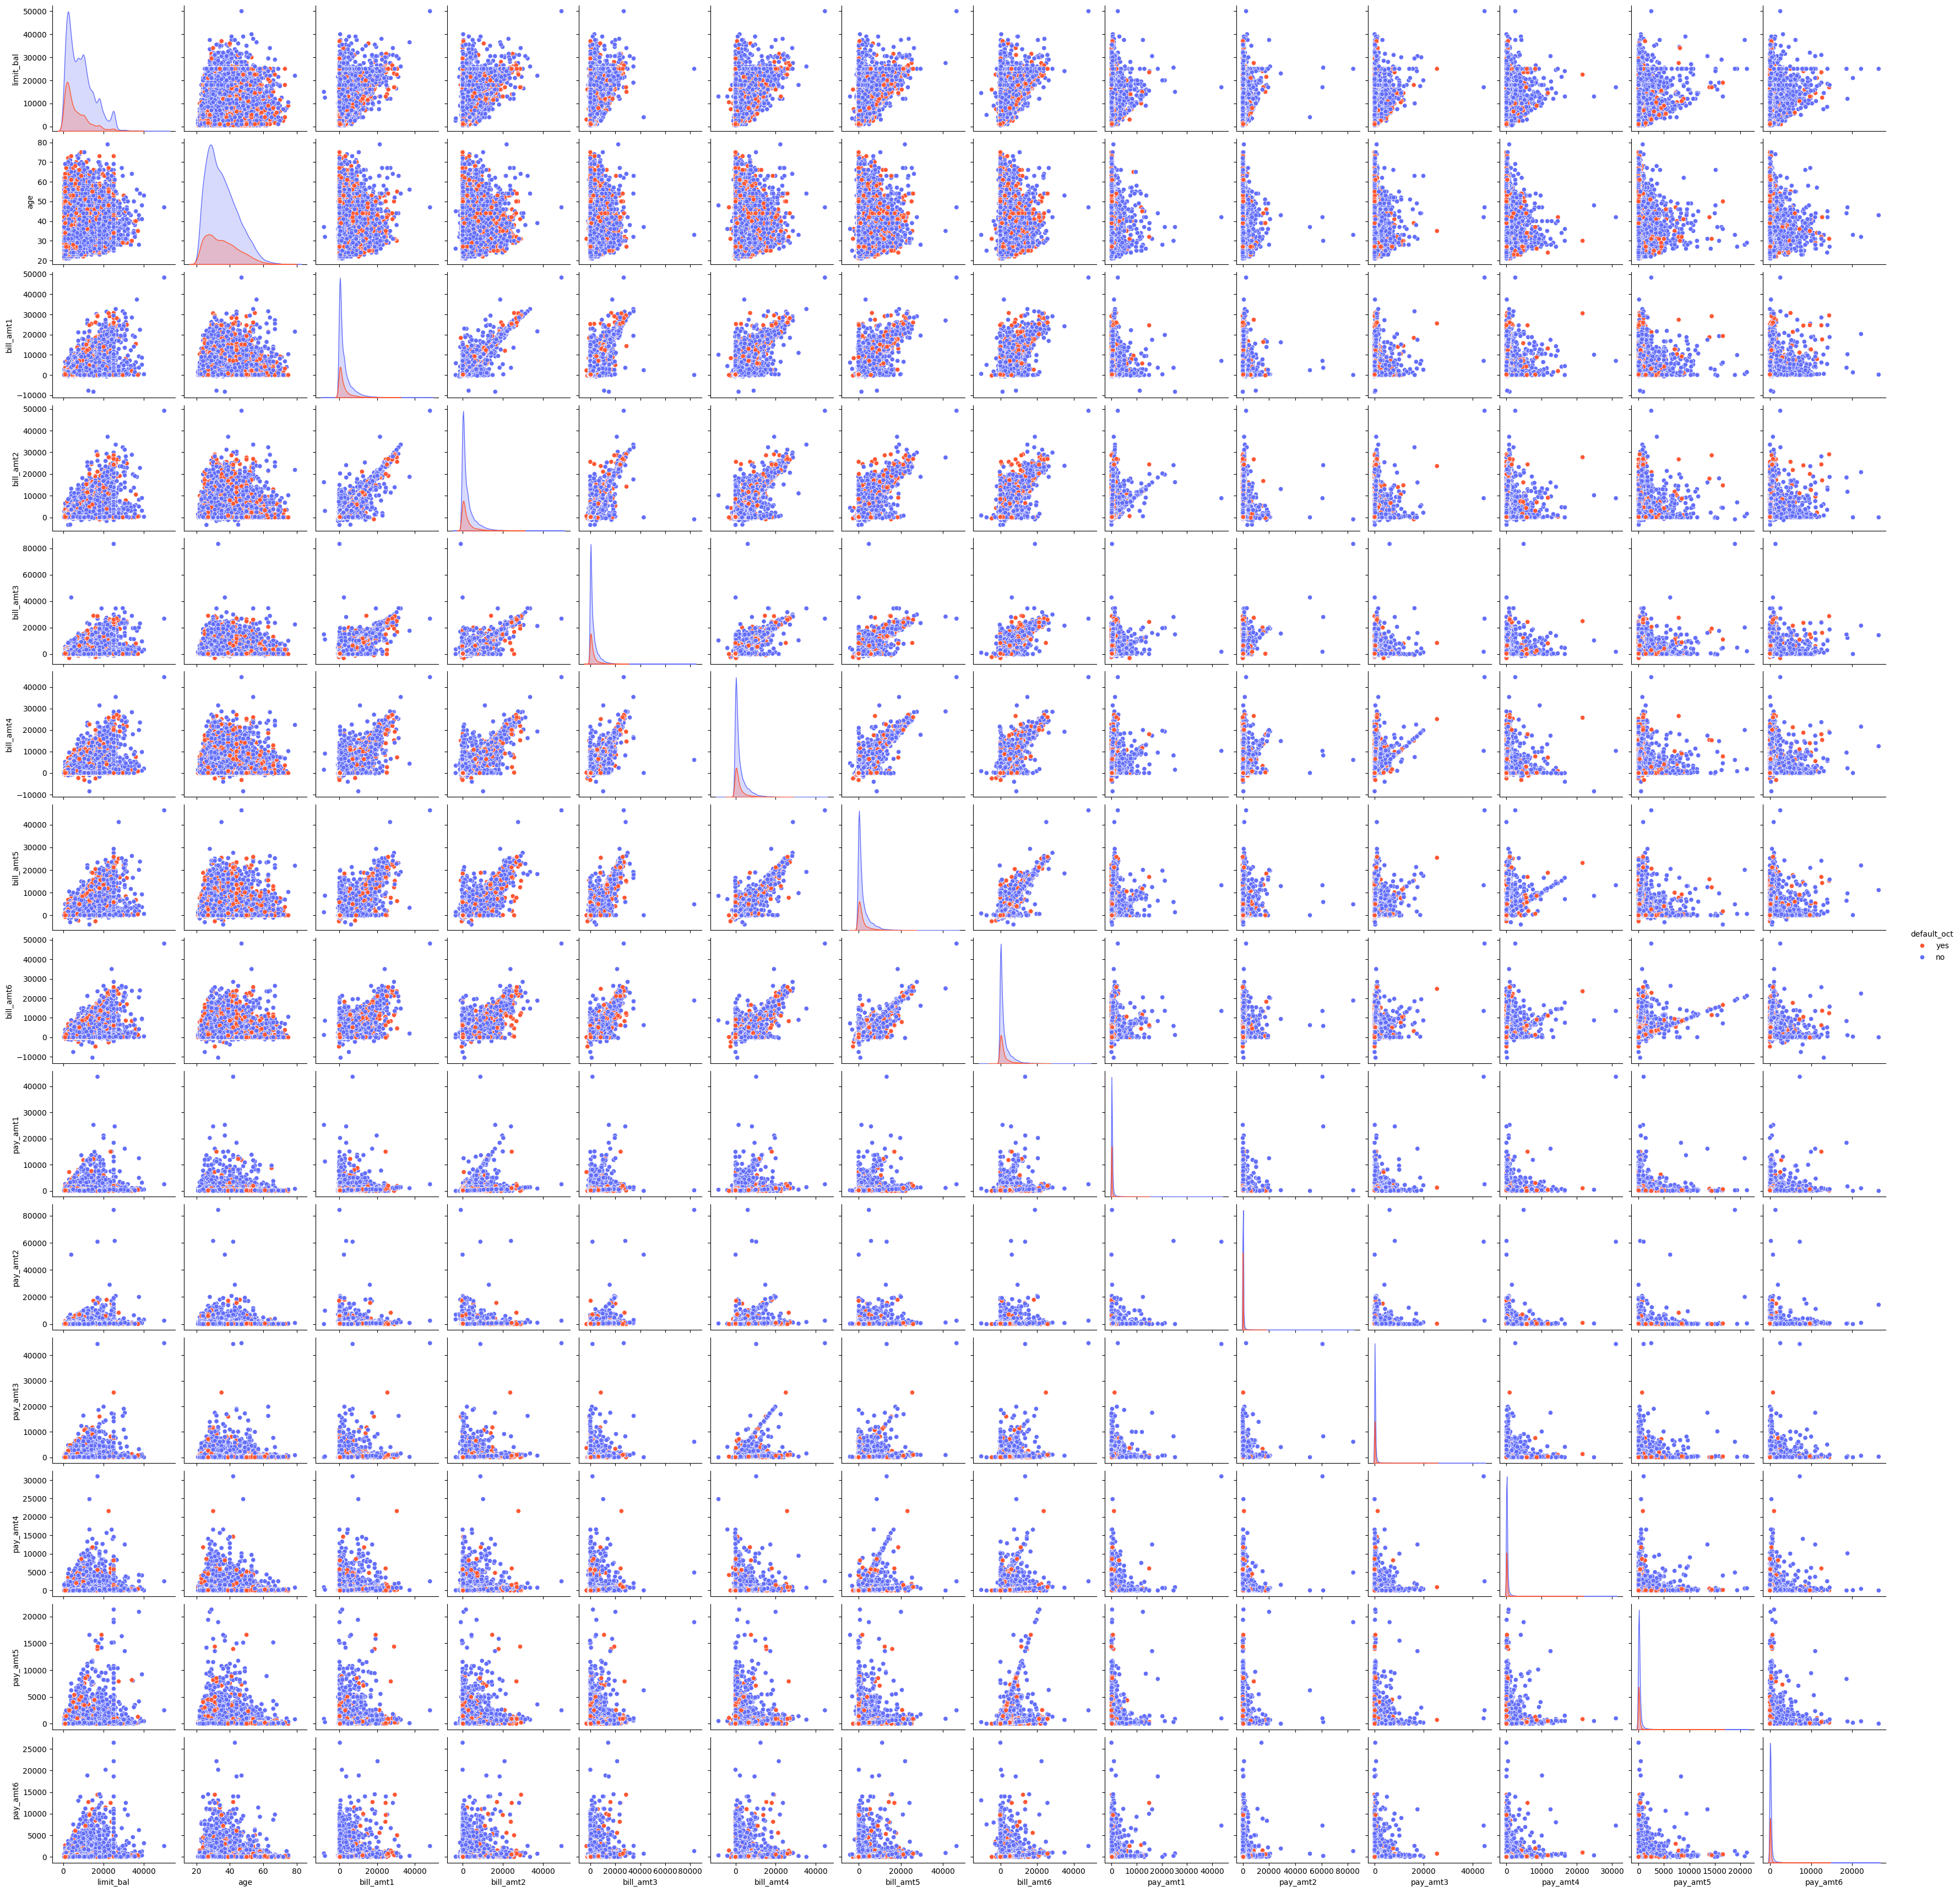

In [17]:
sns.pairplot(train_df, vars=numerical_columns, hue='default_oct', palette={'no': plotly_blue, 'yes': plotly_red}) 
plt.show()

### Correlation Analysis

In [18]:
target = 'default_oct'

for feature in categorical_columns:
    contingency_table = pd.crosstab(train_df[feature], train_df[target])

    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f'Feature: {feature}, Chi-square Statistic: {chi2:.2f}, p-value: {p:.4f}')

    if p < 0.05:
        print(f" --> The association between {feature} and {target} is statistically significant.\n")
    else:
        print(f" --> No significant association found between {feature} and {target}.\n")


Feature: sex, Chi-square Statistic: 31.84, p-value: 0.0000
 --> The association between sex and default_oct is statistically significant.

Feature: education, Chi-square Statistic: 133.22, p-value: 0.0000
 --> The association between education and default_oct is statistically significant.

Feature: marriage, Chi-square Statistic: 32.28, p-value: 0.0000
 --> The association between marriage and default_oct is statistically significant.

Feature: pay_1, Chi-square Statistic: 4175.12, p-value: 0.0000
 --> The association between pay_1 and default_oct is statistically significant.

Feature: pay_2, Chi-square Statistic: 2701.04, p-value: 0.0000
 --> The association between pay_2 and default_oct is statistically significant.

Feature: pay_3, Chi-square Statistic: 2045.02, p-value: 0.0000
 --> The association between pay_3 and default_oct is statistically significant.

Feature: pay_4, Chi-square Statistic: 1855.21, p-value: 0.0000
 --> The association between pay_4 and default_oct is statisti

### Target Variable

In [19]:
train_df['default_oct'].value_counts(normalize=True)

default_oct
no     0.778801
yes    0.221199
Name: proportion, dtype: float64

**Observations**:

- The target variable `default_oct` is binary, with two classes: "no" and "yes", representing customers who did not default and those who did default, respectively.

- The dataset is imbalanced, with approximately 77.88% of customers labeled as "no" and only about 22.12% labeled as "yes".

- This class imbalance could potentially affect the performance of classification models, particularly those sensitive to class distribution, such as logistic regression or decision trees.

- When evaluating model performance, it will be important to consider metrics beyond accuracy, such as precision, recall, and ROC-AUC, to ensure the model's effectiveness in capturing both classes adequately.

- Techniques like resampling (e.g., oversampling the minority class or undersampling the majority class), using appropriate evaluation metrics, or employing algorithms robust to class imbalance (e.g., ensemble methods) may be necessary to address the imbalance and build a reliable predictive model.


## Model Building

### Variable Definitions

In [30]:
param_grid_logistic = {
    'classifier__C': np.logspace(-5, 5, 11),  
    'classifier__penalty': ['l1', 'l2'],  
    'classifier__solver': ['liblinear', 'saga']  
}

param_grid_rf = {
    'classifier__n_estimators': [ 100, 200, 500],  
    'classifier__max_depth': [None, 5, 10, 20, 30],  
    'classifier__min_samples_split': [2, 5, 10],  
    'classifier__min_samples_leaf': [1, 2, 4]  
}

param_grid_gbm = {
    'classifier__n_estimators': [100, 200, 300],  
    'classifier__learning_rate': [0.001, 0.01, 0.1, 0.2], 
    'classifier__max_depth': [3, 5, 7, 9],  
    'classifier__subsample': [0.5, 0.75, 1.0]  
}

In [31]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [32]:
numerical_columns = ['limit_bal', 'age', 'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 
                   'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']
categorical_columns = ['sex', 'education', 'marriage', 'pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']

In [33]:

X = train_df.drop(columns=['default_oct', 'customer_id'])
y = train_df['default_oct'].map({'yes': 1, 'no': 0})  



### Functions

In [34]:
def create_and_save_submission(model_pipeline, X_test, id_column, file_path):
    """
    Generate predictions using the provided model pipeline and create a submission file.
    
    Parameters:
    - model_pipeline: The trained model pipeline capable of calling `predict_proba`.
    - X_test: DataFrame containing the test features.
    - id_column: String, name of the column in X_test containing the IDs.
    - file_path: String, the path (including the file name) where the submission file should be saved.
    """
    # Ensure the model is trained with `fit` before calling this function
    X_test = test_df.drop(columns=['customer_id'])  
    test_pred = model_pipeline.predict_proba(X_test)[:, 1]  
    
    # Create a submission DataFrame
    submission = pd.DataFrame({
        'customer_id': test_df[id_column],
        'pr_y': test_pred
    })

    submission.to_csv(file_path, index=False)
    print(f"Submission file saved to {file_path}")


In [35]:

def create_pipeline(numerical_columns, categorical_columns, classifier, imputer_type='simple_median'):
    """
    Creates a machine learning pipeline that preprocesses data and applies a classifier.
    
    Parameters:
    - numerical_columns: List of strings, names of the numerical columns.
    - categorical_columns: List of strings, names of the categorical columns.
    - classifier: The classifier to use in the pipeline.
    - imputer_type: String, the type of imputer to use ('simple_median', 'knn', or 'iterative').
    
    Returns:
    - An imbalanced-learn pipeline with preprocessing, SMOTE, and classification.
    """
    # Select the imputer based on the imputer_type argument
    if imputer_type == 'knn':
        numeric_imputer = KNNImputer()
    elif imputer_type == 'iterative':
        numeric_imputer = IterativeImputer(random_state=0)
    else:  # Default to 'simple_median'
        numeric_imputer = SimpleImputer(strategy='median')

    # Define the transformers for the numerical and categorical columns
    numeric_transformer = Pipeline(steps=[
        ('imputer', numeric_imputer),
        ('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    # Combine the transformers in a ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_columns),
            ('cat', categorical_transformer, categorical_columns)])

    # Create the final pipeline, including the preprocessor, SMOTE, and the classifier
    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', classifier)
    ])
    
    return pipeline


In [36]:
def get_optuna_suggestions(trial, param_grid):
    """
    The get_optuna_suggestions function generates Optuna parameter suggestions for hyperparameter optimization based on the given parameter grid and Optuna Trial object.

    Args:
        trial (optuna.trial.Trial): An Optuna Trial object representing a single optimization trial.
        param_grid (dict): A dictionary containing the hyperparameter grid with parameter names as keys and corresponding search spaces as values.

    Returns:
        dict: A dictionary containing the Optuna parameter suggestions based on the provided parameter grid.
    """
    optuna_params = {}
    for key, values in param_grid.items():
        param_name = key.replace("classifier__", "")  # Removing 'classifier__' prefix

        if isinstance(values, np.ndarray) or isinstance(values, list):
            # Log scale for 'C' and 'learning_rate', categorical for others
            if param_name in ['C', 'learning_rate'] and isinstance(values, np.ndarray):
                optuna_params[param_name] = trial.suggest_float(param_name, np.min(values), np.max(values), log=True)
            else:
                optuna_params[param_name] = trial.suggest_categorical(param_name, values)
        elif isinstance(values, tuple) and len(values) == 2:
            # Assuming tuple defines a range
            if param_name in ['C', 'learning_rate']:
                optuna_params[param_name] = trial.suggest_float(param_name, values[0], values[1], log=True)
            elif all(isinstance(v, int) for v in values):
                optuna_params[param_name] = trial.suggest_int(param_name, values[0], values[1])
            else:
                optuna_params[param_name] = trial.suggest_float(param_name, values[0], values[1])

    return optuna_params


In [37]:
def tune_classifier(classifier, param_distributions, X, y, numerical_columns, categorical_columns, imputer_type='simple_median', method='randomized_search', n_trials=2, cv=5):
    """
    Tunes a classifier's hyperparameters using either RandomizedSearchCV or Optuna based on the selected method.

    Parameters:
    - classifier (estimator): The machine learning classifier to be tuned.
    - param_distributions (dict): Dictionary with parameters names as keys and distributions or lists of parameters to try.
    - X (DataFrame): Feature dataset used for training the classifier.
    - y (Series/array): Target variable.
    - numerical_columns (list): List of names of the numerical columns in X.
    - categorical_columns (list): List of names of the categorical columns in X.
    - imputer_type (str, optional): Type of imputation strategy for missing values. Default is 'simple_median'.
    - method (str, optional): The method to use for hyperparameter tuning. Options include 'randomized_search' or 'optuna'. Default is 'randomized_search'.
    - n_trials (int, optional): Number of trials for the tuning process. Default is 2.
    - cv (int, optional): Number of cross-validation folds. Default is 5.

    Returns:
    - If using 'randomized_search': Returns the best estimator after the search.
    - If using 'optuna': Returns a pipeline with the best model set with the optimal parameters found.

    Raises:
    - ValueError: If an invalid method is specified.
    """
    if method == 'randomized_search':
        pipeline = create_pipeline(numerical_columns, categorical_columns, classifier, imputer_type=imputer_type)
        search = RandomizedSearchCV(pipeline, param_distributions, n_iter=n_trials, cv=cv, scoring='neg_log_loss', n_jobs=-1, verbose=3)
        search.fit(X, y)
        return search.best_estimator_
    elif method == 'optuna':
        def objective(trial):
            optuna_params = get_optuna_suggestions(trial, param_distributions)
            model = classifier.set_params(**optuna_params)
            pipeline = create_pipeline(numerical_columns, categorical_columns, model, imputer_type=imputer_type)
            score = cross_val_score(pipeline, X, y, cv=cv, scoring='neg_log_loss', n_jobs=-1).mean()
            return -score
        
        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=n_trials)
        best_params = study.best_trial.params
        best_model = classifier.set_params(**best_params)
        return create_pipeline(numerical_columns, categorical_columns, best_model, imputer_type=imputer_type)
    else:
        raise ValueError("Invalid method specified. Choose 'randomized_search' or 'optuna'.")


In [38]:
def train_and_evaluate_ensemble(X, y, best_classifiers, cv=5):
    """
    Trains and evaluates two types of ensemble models: a Voting Classifier and a Stacking Classifier. 
    Both classifiers use the provided best classifiers as base learners.

    Parameters:
    - X (DataFrame): Feature dataset used for training the classifiers.
    - y (Series/array): Target variable.
    - best_classifiers (tuple): A tuple containing the best models for logistic regression, random forest,
      and gradient boosting machine, respectively.
    - cv (int, optional): Number of cross-validation folds. Default is 5.

    Returns:
    - voting_clf (VotingClassifier): The trained Voting Classifier which uses soft voting.
    - stacking_clf (StackingClassifier): The trained Stacking Classifier with logistic regression as the final estimator.

    The function prints the negative log loss for both the Voting and Stacking classifiers calculated using cross-validation.
    """
    
    # Unpack the best classifiers
    best_logistic, best_rf, best_gbm = best_classifiers
    
    # Create ensemble models
    voting_clf = VotingClassifier(estimators=[
        ('lr', best_logistic), ('rf', best_rf), ('gb', best_gbm)], voting='soft')
    stacking_clf = StackingClassifier(estimators=[
        ('lr', best_logistic), ('rf', best_rf), ('gb', best_gbm)],
        final_estimator=LogisticRegression())

    # Train and evaluate the Voting Classifier
    voting_scores = cross_val_score(voting_clf, X, y, cv=cv, scoring='neg_log_loss', n_jobs=-1)
    print(f"Voting Classifier Log Loss: {-np.mean(voting_scores)}")

    # Train and evaluate the Stacking Classifier
    stacking_scores = cross_val_score(stacking_clf, X, y, cv=cv, scoring='neg_log_loss', n_jobs=-1)
    print(f"Stacking Classifier Log Loss: {-np.mean(stacking_scores)}")

    return voting_clf, stacking_clf


In [39]:
def add_demographic_interactions(df, numerical_columns, categorical_columns):
    """
    Adds a new categorical feature representing the interaction between 'education' and 'marriage' columns.

    Parameters:
    - df (DataFrame): The DataFrame containing the data.
    - numerical_columns (list): List of column names considered as numerical features.
    - categorical_columns (list): List of column names considered as categorical features.

    Returns:
    - df (DataFrame): Updated DataFrame with the new categorical feature added.
    - numerical_columns (list): Unmodified list of numerical columns.
    - categorical_columns (list): Updated list of categorical columns including the new feature.
    """
    # Interaction between education and marriage
    new_feature = 'edu_marriage_interaction'
    df[new_feature] = df['education'].astype(str) + "_" + df['marriage'].astype(str)
    
    # Update categorical columns list
    categorical_columns.append(new_feature)
    return df, numerical_columns, categorical_columns

def add_payment_bill_ratios(df, numerical_columns, categorical_columns):
    """
    Adds new numerical features to the DataFrame for each month calculating the ratio of payment amount to bill amount.

    Parameters:
    - df (DataFrame): The DataFrame containing the data.
    - numerical_columns (list): List of column names considered as numerical features.
    - categorical_columns (list): List of column names considered as categorical features.

    Returns:
    - df (DataFrame): Updated DataFrame with new numerical features.
    - numerical_columns (list): Updated list of numerical columns including the new features.
    - categorical_columns (list): Unmodified list of categorical columns.
    """
    new_features = []
    for i in range(1, 7):
        # Ensure bill amounts less than 0 are set to 0
        bill_amt_col = f'bill_amt{i}'
        df[bill_amt_col] = df[bill_amt_col].apply(lambda x: max(x, 0))
        
        # Calculate the pay-to-bill ratio, safely handling division by zero
        new_feature = f'pay_bill_ratio_{i}'
        df[new_feature] = df[f'pay_amt{i}'] / (df[bill_amt_col] + 1)
        new_features.append(new_feature)

    # Update numerical columns list
    numerical_columns.extend(new_features)
    return df, numerical_columns, categorical_columns

def aggregate_payment_bill_features(df, numerical_columns, categorical_columns):
    """
    Aggregates payment and bill amounts across all months to create total payment and bill amounts and their ratio.

    Parameters:
    - df (DataFrame): The DataFrame containing the data.
    - numerical_columns (list): List of column names considered as numerical features.
    - categorical_columns (list): List of column names considered as categorical features.

    Returns:
    - df (DataFrame): Updated DataFrame with aggregated payment and bill features.
    - numerical_columns (list): Updated list of numerical columns including the aggregated features.
    - categorical_columns (list): Unmodified list of categorical columns.
    """
    new_features = ['total_bill_amt', 'total_pay_amt', 'bill_pay_ratio']
    bill_amt_features = [f'bill_amt{i}' for i in range(1, 7)]
    pay_amt_features = [f'pay_amt{i}' for i in range(1, 7)]
    
    df['total_bill_amt'] = df[bill_amt_features].sum(axis=1)
    df['total_pay_amt'] = df[pay_amt_features].sum(axis=1)
    df['bill_pay_ratio'] = df['total_pay_amt'] / (df['total_bill_amt'] + 1)
    
    # Update numerical columns list
    numerical_columns.extend(new_features)
    return df, numerical_columns, categorical_columns

def bin_age_groups(df, numerical_columns, categorical_columns):
    """
    Bins the 'age' column into predefined age groups and adds it as a new categorical feature to the DataFrame.

    Parameters:
    - df (DataFrame): The DataFrame containing the data.
    - numerical_columns (list): List of column names considered as numerical features.
    - categorical_columns (list): List of column names considered as categorical features.

    Returns:
    - df (DataFrame): Updated DataFrame with the new categorical feature 'age_group'.
    - numerical_columns (list): Unmodified list of numerical columns.
    - categorical_columns (list): Updated list of categorical columns including the new 'age_group' feature.
    """
    new_feature = 'age_group'
    bins = [20, 30, 40, 50, 60, 70, 80]
    labels = ['20-29', '30-39', '40-49', '50-59', '60-69', '70-79']
    df[new_feature] = pd.cut(df['age'], bins=bins, labels=labels, right=False)
    
    # Update categorical columns list
    categorical_columns.append(new_feature)
    return df, numerical_columns, categorical_columns

def apply_transformations(df, numerical_columns, categorical_columns):
    """
    Applies a sequence of transformations to the DataFrame including adding interactions, ratios, aggregates, and binning.

    Parameters:
    - df (DataFrame): The DataFrame to be transformed.
    - numerical_columns (list): List of column names considered as numerical features.
    - categorical_columns (list): List of column names considered as categorical features.

    Returns:
    - df (DataFrame): Fully transformed DataFrame.
    - numerical_columns (list): Updated list of numerical columns after all transformations.
    - categorical_columns (list): Updated list of categorical columns after all transformations.
    """
    df, numerical_columns, categorical_columns = add_demographic_interactions(df, numerical_columns, categorical_columns)
    df, numerical_columns, categorical_columns = add_payment_bill_ratios(df, numerical_columns, categorical_columns)
    df, numerical_columns, categorical_columns = aggregate_payment_bill_features(df, numerical_columns, categorical_columns)
    df, numerical_columns, categorical_columns = bin_age_groups(df, numerical_columns, categorical_columns)
    return df, numerical_columns, categorical_columns


In [40]:
def create_preprocessor(numerical_columns, categorical_columns):
    """
    Creates a preprocessing pipeline for numerical and categorical data. The pipeline includes imputation
    and scaling for numerical features, and imputation and one-hot encoding for categorical features.

    Parameters:
    - numerical_columns (list): List of column names to be treated as numerical features.
    - categorical_columns (list): List of column names to be treated as categorical features.

    Returns:
    - preprocessor (ColumnTransformer): A preprocessor object that includes two pipelines:
      1. A pipeline for numerical data that imputes missing values with the median and then scales the data.
      2. A pipeline for categorical data that imputes missing values with the most frequent category and
         applies one-hot encoding, ignoring unknown categories during transformation.

    The function constructs and returns a ColumnTransformer which can be directly used with machine learning
    models to handle preprocessing of both numerical and categorical data within model training pipelines.
    """
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_columns),
            ('cat', categorical_transformer, categorical_columns)])
    
    return preprocessor


In [41]:
def cluster_with_optuna(df, numerical_columns, categorical_columns, n_trials=10, algorithm='kmeans'):
    """
    Uses the Optuna framework to optimize clustering algorithm hyperparameters and applies the best 
    clustering model to the data. Supported algorithms are KMeans and DBSCAN.

    Parameters:
    - df (DataFrame): The DataFrame containing the data to be clustered.
    - numerical_columns (list): List of column names to be treated as numerical features.
    - categorical_columns (list): List of column names to be treated as categorical features.
    - n_trials (int, optional): The number of trials for Optuna optimization. Default is 10.
    - algorithm (str, optional): The clustering algorithm to use. Supported values are 'kmeans' and 'dbscan'. Default is 'kmeans'.

    Returns:
    - df (DataFrame): The original DataFrame with an additional column 'cluster_label' indicating the cluster assignment.
    - final_pipeline (Pipeline): A pipeline that includes preprocessing and the optimized clustering model.

    The function performs the following steps:
    1. Preprocesses the data using specified numerical and categorical columns.
    2. Uses Optuna to find the best hyperparameters for the specified clustering algorithm.
    3. Applies the best model to the data and labels each row with its cluster assignment.
    
    Raises:
    - ValueError: If an unsupported clustering algorithm is specified.

    Each Optuna trial consists of fitting the model with a set of hyperparameters and computing the silhouette score
    to evaluate clustering quality. The best model is selected based on the highest silhouette score.
    """
    preprocessor = create_preprocessor(numerical_columns, categorical_columns)
    
    def objective(trial):
        if algorithm == 'kmeans':
            n_clusters = trial.suggest_int('n_clusters', 2, 50)
            model = KMeans(n_clusters=n_clusters, random_state=42)
        elif algorithm == 'dbscan':
            eps = trial.suggest_float('eps', 0.1, 15.0)
            min_samples = trial.suggest_int('min_samples', 2, 20)
            model = DBSCAN(eps=eps, min_samples=min_samples)
        else:
            raise ValueError("Unsupported algorithm specified.")
        
        # Combine preprocessing and clustering into a single pipeline
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('cluster', model)
        ])
        
        # Fit the pipeline and calculate silhouette score
        pipeline.fit(df[numerical_columns + categorical_columns])
        labels = pipeline.named_steps['cluster'].labels_
        
        # Print number of clusters (unique labels) found in this trial
        # Note: For DBSCAN, "-1" indicates noise
        num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        print(f"Trial {trial.number}: Found {num_clusters} clusters.")
        
        # Handle cases with fewer than 2 clusters
        if len(set(labels)) < 2:
            return -1
        
        silhouette_avg = silhouette_score(
            preprocessor.transform(df[numerical_columns + categorical_columns]), 
            labels)
        return silhouette_avg

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)

    # Recreate and fit the model with the best hyperparameters
    if algorithm == 'kmeans':
        best_n_clusters = study.best_params['n_clusters']
        final_model = KMeans(n_clusters=best_n_clusters, random_state=42)
    elif algorithm == 'dbscan':
        best_eps = study.best_params['eps']
        best_min_samples = study.best_params['min_samples']
        final_model = DBSCAN(eps=best_eps, min_samples=best_min_samples)
    
    final_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('cluster', final_model)
    ])
    final_pipeline.fit(df[numerical_columns + categorical_columns])
    df['cluster_label'] = final_pipeline.named_steps['cluster'].labels_
    
    return df, final_pipeline


### Base Model

In [32]:
# Model initialization
logreg_model = LogisticRegression(max_iter=1000)

logreg_pipeline = create_pipeline(numerical_columns, categorical_columns, logreg_model)

# Stratified K-Fold cross-validation
cv = StratifiedKFold(n_splits=5)

# Compute the cross-validated log-loss
scores = cross_val_score(logreg_pipeline, X, y, scoring='neg_log_loss', cv=cv)
average_log_loss = -scores.mean()
print(f'Average Log Loss: {average_log_loss}')


Average Log Loss: 0.568532913440925


In [33]:
# Train the model on the full dataset
logreg_pipeline.fit(X, y)
create_and_save_submission(logreg_pipeline, test_df, 'customer_id', '../GaneshMorye_predictions.csv')


Submission file saved to ../GaneshMorye_predictions.csv


### Missing Values Imputation

In [34]:
# Tune each classifier
best_logistic_optuna_imputed = tune_classifier(
    LogisticRegression(max_iter=1000),  # classifier instance
    param_grid_logistic,   # parameter distribution
    X,                     # features
    y,                     # target variable
    numerical_columns,     # list of names of numerical columns
    categorical_columns,   # list of names of categorical columns
    method='optuna',  # method of hyperparameter optimization
    n_trials=25,            # number of iterations/trials
    cv=cv,
    imputer_type='knn'
)


[I 2024-03-29 20:47:27,711] A new study created in memory with name: no-name-9e347e2d-b87e-4fa7-8749-e44fd6c9d47b
[I 2024-03-29 20:47:36,801] Trial 0 finished with value: 0.5680833286096206 and parameters: {'C': 0.24987384303748789, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 0 with value: 0.5680833286096206.
[I 2024-03-29 20:47:45,809] Trial 1 finished with value: 0.5694412516610049 and parameters: {'C': 6.298628470471165, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 0 with value: 0.5680833286096206.
[I 2024-03-29 20:47:54,507] Trial 2 finished with value: 0.5683103733116319 and parameters: {'C': 0.012348727987256738, 'penalty': 'l2', 'solver': 'saga'}. Best is trial 0 with value: 0.5680833286096206.
[I 2024-03-29 20:48:01,211] Trial 3 finished with value: 0.580315351878448 and parameters: {'C': 0.0009741832765718669, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 0 with value: 0.5680833286096206.
[I 2024-03-29 20:48:10,438] Trial 4 finished with value: 0.

In [35]:
# Compute the cross-validated log-loss
scores = cross_val_score(best_logistic_optuna_imputed, X, y, scoring='neg_log_loss', cv=cv)
average_log_loss = -scores.mean()
print(f'Average Log Loss with KNN Imputation is: {average_log_loss}')

Average Log Loss with KNN Imputation is: 0.5674983666306952


In [36]:
best_logistic_optuna_imputed = tune_classifier(
    LogisticRegression(max_iter=1000),  # classifier instance
    param_grid_logistic,   # parameter distribution
    X,                     # features
    y,                     # target variable
    numerical_columns,     # list of names of numerical columns
    categorical_columns,   # list of names of categorical columns
    method='optuna',  # method of hyperparameter optimization
    n_trials=25,            # number of iterations/trials
    cv=cv,
    imputer_type='iterative'
)

[I 2024-03-29 20:52:04,383] A new study created in memory with name: no-name-cc1cd6d2-6ee0-4937-87d4-f8636d01d29b
[I 2024-03-29 20:52:11,886] Trial 0 finished with value: 0.5743989721915181 and parameters: {'C': 3344.2058034903193, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 0 with value: 0.5743989721915181.
/Users/ganeshmorye/miniconda3/envs/arene-woven/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ganeshmorye/miniconda3/envs/arene-woven/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ganeshmorye/miniconda3/envs/arene-woven/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ganeshmorye/miniconda3/envs/arene-woven

In [37]:
# Compute the cross-validated log-loss
scores = cross_val_score(best_logistic_optuna_imputed, X, y, scoring='neg_log_loss', cv=cv)
average_log_loss = -scores.mean()
print(f'Average Log Loss with Iterative Imputation is: {average_log_loss}')

Average Log Loss with Iterative Imputation is: 0.5675981108337774


In [38]:
best_logistic_optuna_imputed = tune_classifier(
    LogisticRegression(max_iter=1000),  # classifier instance
    param_grid_logistic,   # parameter distribution
    X,                     # features
    y,                     # target variable
    numerical_columns,     # list of names of numerical columns
    categorical_columns,   # list of names of categorical columns
    method='optuna',  # method of hyperparameter optimization
    n_trials=25,            # number of iterations/trials
    cv=cv,
    imputer_type='simple_median'
)

[I 2024-03-29 21:02:54,235] A new study created in memory with name: no-name-1f39a478-d7fa-4a11-ba7f-29cd1a2df42d
[I 2024-03-29 21:03:01,015] Trial 0 finished with value: 0.5735839001106202 and parameters: {'C': 3301.3889501454655, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 0 with value: 0.5735839001106202.
[I 2024-03-29 21:03:08,969] Trial 1 finished with value: 0.6388091186769163 and parameters: {'C': 0.0008245078408778321, 'penalty': 'l1', 'solver': 'saga'}. Best is trial 0 with value: 0.5735839001106202.
[I 2024-03-29 21:03:11,575] Trial 2 finished with value: 0.568019995964417 and parameters: {'C': 0.18892085901456346, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 2 with value: 0.568019995964417.
[I 2024-03-29 21:03:17,408] Trial 3 finished with value: 0.6035719011924374 and parameters: {'C': 0.0002507765055673544, 'penalty': 'l2', 'solver': 'saga'}. Best is trial 2 with value: 0.568019995964417.
[I 2024-03-29 21:03:20,352] Trial 4 finished with value: 0.58115

In [39]:
# Compute the cross-validated log-loss
scores = cross_val_score(best_logistic_optuna_imputed, X, y, scoring='neg_log_loss', cv=cv)
average_log_loss = -scores.mean()
print(f'Average Log Loss with Simple Median Imputation is: {average_log_loss}')

/Users/ganeshmorye/miniconda3/envs/arene-woven/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ganeshmorye/miniconda3/envs/arene-woven/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ganeshmorye/miniconda3/envs/arene-woven/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Average Log Loss with Simple Median Imputation is: 0.567579159408987


/Users/ganeshmorye/miniconda3/envs/arene-woven/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### Ensemble Modeling

In [40]:
# Tune each classifier
best_logistic_rs = tune_classifier(
    LogisticRegression(),  # classifier instance
    param_grid_logistic,   # parameter distribution
    X,                     # features
    y,                     # target variable
    numerical_columns,     # list of names of numerical columns
    categorical_columns,   # list of names of categorical columns
    method='randomized_search',  # method of hyperparameter optimization
    n_trials=25,            # number of iterations/trials
    cv=cv
)

dump(best_logistic_rs, '../models/best_logistic_rs.joblib')

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 2/5] END classifier__C=0.0001, classifier__penalty=l1, classifier__solver=saga;, score=-0.691 total time=   4.1s
[CV 5/5] END classifier__C=0.0001, classifier__penalty=l1, classifier__solver=saga;, score=-0.692 total time=   4.1s
[CV 1/5] END classifier__C=0.0001, classifier__penalty=l1, classifier__solver=saga;, score=-0.692 total time=   4.2s
[CV 3/5] END classifier__C=0.0001, classifier__penalty=l1, classifier__solver=saga;, score=-0.693 total time=   4.2s
[CV 4/5] END classifier__C=0.0001, classifier__penalty=l1, classifier__solver=saga;, score=-0.693 total time=   4.2s
[CV 1/5] END classifier__C=1e-05, classifier__penalty=l1, classifier__solver=saga;, score=-0.695 total time=   2.0s
[CV 3/5] END classifier__C=1e-05, classifier__penalty=l1, classifier__solver=saga;, score=-0.690 total time=   2.0s
[CV 2/5] END classifier__C=1e-05, classifier__penalty=l1, classifier__solver=saga;, score=-0.692 total time=   2.0s
[CV 4

/Users/ganeshmorye/miniconda3/envs/arene-woven/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1.0, classifier__penalty=l1, classifier__solver=saga;, score=-0.569 total time=   8.5s
[CV 2/5] END classifier__C=1.0, classifier__penalty=l1, classifier__solver=saga;, score=-0.562 total time=   8.7s


/Users/ganeshmorye/miniconda3/envs/arene-woven/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ganeshmorye/miniconda3/envs/arene-woven/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1.0, classifier__penalty=l1, classifier__solver=saga;, score=-0.565 total time=   8.8s


/Users/ganeshmorye/miniconda3/envs/arene-woven/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1.0, classifier__penalty=l1, classifier__solver=saga;, score=-0.577 total time=   7.1s


/Users/ganeshmorye/miniconda3/envs/arene-woven/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1.0, classifier__penalty=l1, classifier__solver=saga;, score=-0.567 total time=   7.3s


/Users/ganeshmorye/miniconda3/envs/arene-woven/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100000.0, classifier__penalty=l1, classifier__solver=saga;, score=-0.570 total time=   7.0s


/Users/ganeshmorye/miniconda3/envs/arene-woven/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ganeshmorye/miniconda3/envs/arene-woven/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100000.0, classifier__penalty=l1, classifier__solver=saga;, score=-0.565 total time=   7.0s
[CV 2/5] END classifier__C=100000.0, classifier__penalty=l1, classifier__solver=saga;, score=-0.562 total time=   7.1s


/Users/ganeshmorye/miniconda3/envs/arene-woven/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ganeshmorye/miniconda3/envs/arene-woven/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100000.0, classifier__penalty=l1, classifier__solver=saga;, score=-0.567 total time=   6.9s
[CV 4/5] END classifier__C=100000.0, classifier__penalty=l1, classifier__solver=saga;, score=-0.577 total time=   7.1s
[CV 1/5] END classifier__C=1.0, classifier__penalty=l1, classifier__solver=liblinear;, score=-0.570 total time=   7.5s
[CV 3/5] END classifier__C=1.0, classifier__penalty=l1, classifier__solver=liblinear;, score=-0.564 total time=   5.8s
[CV 5/5] END classifier__C=1.0, classifier__penalty=l1, classifier__solver=liblinear;, score=-0.569 total time=   3.5s
[CV 2/5] END classifier__C=1.0, classifier__penalty=l1, classifier__solver=liblinear;, score=-0.562 total time=   7.6s
[CV 4/5] END classifier__C=1.0, classifier__penalty=l1, classifier__solver=liblinear;, score=-0.578 total time=   6.5s
[CV 1/5] END classifier__C=0.01, classifier__penalty=l2, classifier__solver=liblinear;, score=-0.571 total time=   1.6s
[CV 2/5] END classifier__C=0.01, classifier__pe

/Users/ganeshmorye/miniconda3/envs/arene-woven/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ganeshmorye/miniconda3/envs/arene-woven/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__penalty=l2, classifier__solver=liblinear;, score=-0.578 total time=   1.4s
[CV 2/5] END classifier__C=100.0, classifier__penalty=l1, classifier__solver=saga;, score=-0.562 total time=   6.1s
[CV 5/5] END classifier__C=0.01, classifier__penalty=l2, classifier__solver=liblinear;, score=-0.567 total time=   1.6s
[CV 3/5] END classifier__C=100.0, classifier__penalty=l1, classifier__solver=saga;, score=-0.565 total time=   6.5s


/Users/ganeshmorye/miniconda3/envs/arene-woven/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ganeshmorye/miniconda3/envs/arene-woven/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100.0, classifier__penalty=l1, classifier__solver=saga;, score=-0.577 total time=   6.4s


/Users/ganeshmorye/miniconda3/envs/arene-woven/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100.0, classifier__penalty=l1, classifier__solver=saga;, score=-0.567 total time=   6.9s
[CV 1/5] END classifier__C=100000.0, classifier__penalty=l1, classifier__solver=liblinear;, score=-0.583 total time=   3.7s
[CV 4/5] END classifier__C=100000.0, classifier__penalty=l1, classifier__solver=liblinear;, score=-0.587 total time=   3.4s
[CV 2/5] END classifier__C=100000.0, classifier__penalty=l1, classifier__solver=liblinear;, score=-0.565 total time=   3.8s
[CV 5/5] END classifier__C=100000.0, classifier__penalty=l1, classifier__solver=liblinear;, score=-0.605 total time=   3.3s
[CV 3/5] END classifier__C=100000.0, classifier__penalty=l1, classifier__solver=liblinear;, score=-0.569 total time=   3.9s


/Users/ganeshmorye/miniconda3/envs/arene-woven/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100.0, classifier__penalty=l2, classifier__solver=saga;, score=-0.570 total time=   6.7s


/Users/ganeshmorye/miniconda3/envs/arene-woven/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100.0, classifier__penalty=l2, classifier__solver=saga;, score=-0.562 total time=   6.3s


/Users/ganeshmorye/miniconda3/envs/arene-woven/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100.0, classifier__penalty=l2, classifier__solver=saga;, score=-0.565 total time=   5.9s


/Users/ganeshmorye/miniconda3/envs/arene-woven/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ganeshmorye/miniconda3/envs/arene-woven/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100.0, classifier__penalty=l2, classifier__solver=saga;, score=-0.577 total time=   5.7s
[CV 5/5] END classifier__C=100.0, classifier__penalty=l2, classifier__solver=saga;, score=-0.567 total time=   5.7s


/Users/ganeshmorye/miniconda3/envs/arene-woven/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ganeshmorye/miniconda3/envs/arene-woven/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ganeshmorye/miniconda3/envs/arene-woven/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10.0, classifier__penalty=l2, classifier__solver=saga;, score=-0.570 total time=   5.7s
[CV 3/5] END classifier__C=10.0, classifier__penalty=l2, classifier__solver=saga;, score=-0.565 total time=   5.5s
[CV 2/5] END classifier__C=10.0, classifier__penalty=l2, classifier__solver=saga;, score=-0.562 total time=   5.7s


/Users/ganeshmorye/miniconda3/envs/arene-woven/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10.0, classifier__penalty=l2, classifier__solver=saga;, score=-0.577 total time=   4.0s


/Users/ganeshmorye/miniconda3/envs/arene-woven/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10.0, classifier__penalty=l2, classifier__solver=saga;, score=-0.567 total time=   4.3s
[CV 1/5] END classifier__C=0.001, classifier__penalty=l1, classifier__solver=saga;, score=-0.626 total time=   3.3s
[CV 1/5] END classifier__C=0.0001, classifier__penalty=l2, classifier__solver=liblinear;, score=-0.627 total time=   2.5s
[CV 4/5] END classifier__C=0.001, classifier__penalty=l1, classifier__solver=saga;, score=-0.626 total time=   3.0s
[CV 3/5] END classifier__C=0.001, classifier__penalty=l1, classifier__solver=saga;, score=-0.628 total time=   3.4s
[CV 2/5] END classifier__C=0.001, classifier__penalty=l1, classifier__solver=saga;, score=-0.624 total time=   3.9s
[CV 2/5] END classifier__C=0.0001, classifier__penalty=l2, classifier__solver=liblinear;, score=-0.625 total time=   2.0s
[CV 5/5] END classifier__C=0.001, classifier__penalty=l1, classifier__solver=saga;, score=-0.624 total time=   4.0s
[CV 3/5] END classifier__C=0.0001, classifier__penalty=l2, cl

/Users/ganeshmorye/miniconda3/envs/arene-woven/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1000.0, classifier__penalty=l2, classifier__solver=saga;, score=-0.570 total time=   5.0s
[CV 1/5] END classifier__C=1.0, classifier__penalty=l2, classifier__solver=liblinear;, score=-0.570 total time=   2.6s
[CV 4/5] END classifier__C=1000.0, classifier__penalty=l2, classifier__solver=liblinear;, score=-0.583 total time=   5.9s
[CV 5/5] END classifier__C=1000.0, classifier__penalty=l2, classifier__solver=liblinear;, score=-0.580 total time=   5.5s


/Users/ganeshmorye/miniconda3/envs/arene-woven/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1000.0, classifier__penalty=l2, classifier__solver=saga;, score=-0.562 total time=   4.9s


/Users/ganeshmorye/miniconda3/envs/arene-woven/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1000.0, classifier__penalty=l2, classifier__solver=saga;, score=-0.577 total time=   4.6s
[CV 3/5] END classifier__C=1000.0, classifier__penalty=l2, classifier__solver=saga;, score=-0.565 total time=   5.0s


/Users/ganeshmorye/miniconda3/envs/arene-woven/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ganeshmorye/miniconda3/envs/arene-woven/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1000.0, classifier__penalty=l2, classifier__solver=saga;, score=-0.567 total time=   4.6s
[CV 3/5] END classifier__C=1.0, classifier__penalty=l2, classifier__solver=liblinear;, score=-0.564 total time=   3.4s
[CV 5/5] END classifier__C=1.0, classifier__penalty=l2, classifier__solver=liblinear;, score=-0.569 total time=   3.2s
[CV 2/5] END classifier__C=1.0, classifier__penalty=l2, classifier__solver=liblinear;, score=-0.562 total time=   3.6s
[CV 4/5] END classifier__C=1.0, classifier__penalty=l2, classifier__solver=liblinear;, score=-0.578 total time=   3.5s
[CV 1/5] END classifier__C=10000.0, classifier__penalty=l2, classifier__solver=liblinear;, score=-0.574 total time=   6.0s
[CV 3/5] END classifier__C=10000.0, classifier__penalty=l2, classifier__solver=liblinear;, score=-0.567 total time=   6.3s
[CV 2/5] END classifier__C=10000.0, classifier__penalty=l2, classifier__solver=liblinear;, score=-0.564 total time=   6.7s
[CV 4/5] END classifier__C=10000.0, cl

/Users/ganeshmorye/miniconda3/envs/arene-woven/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ganeshmorye/miniconda3/envs/arene-woven/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ganeshmorye/miniconda3/envs/arene-woven/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__penalty=l2, classifier__solver=saga;, score=-0.563 total time=   5.2s
[CV 3/5] END classifier__C=0.01, classifier__penalty=l2, classifier__solver=saga;, score=-0.565 total time=   5.2s
[CV 1/5] END classifier__C=0.01, classifier__penalty=l2, classifier__solver=saga;, score=-0.570 total time=   5.3s
[CV 1/5] END classifier__C=1e-05, classifier__penalty=l2, classifier__solver=liblinear;, score=-0.678 total time=   1.5s
[CV 5/5] END classifier__C=10000.0, classifier__penalty=l2, classifier__solver=liblinear;, score=-0.582 total time=   6.1s
[CV 2/5] END classifier__C=1e-05, classifier__penalty=l2, classifier__solver=liblinear;, score=-0.678 total time=   1.5s


/Users/ganeshmorye/miniconda3/envs/arene-woven/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__penalty=l2, classifier__solver=saga;, score=-0.578 total time=   4.2s
[CV 3/5] END classifier__C=1e-05, classifier__penalty=l2, classifier__solver=liblinear;, score=-0.678 total time=   2.5s
[CV 5/5] END classifier__C=1e-05, classifier__penalty=l2, classifier__solver=liblinear;, score=-0.678 total time=   2.6s
[CV 4/5] END classifier__C=1e-05, classifier__penalty=l2, classifier__solver=liblinear;, score=-0.679 total time=   2.6s


/Users/ganeshmorye/miniconda3/envs/arene-woven/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__penalty=l2, classifier__solver=saga;, score=-0.567 total time=   4.6s
[CV 1/5] END classifier__C=1000.0, classifier__penalty=l1, classifier__solver=liblinear;, score=-0.582 total time=   3.0s
[CV 2/5] END classifier__C=1000.0, classifier__penalty=l1, classifier__solver=liblinear;, score=-0.564 total time=   3.3s
[CV 3/5] END classifier__C=1000.0, classifier__penalty=l1, classifier__solver=liblinear;, score=-0.568 total time=   3.3s
[CV 1/5] END classifier__C=1e-05, classifier__penalty=l1, classifier__solver=liblinear;, score=-0.693 total time=   2.2s
[CV 2/5] END classifier__C=1e-05, classifier__penalty=l1, classifier__solver=liblinear;, score=-0.693 total time=   2.2s
[CV 4/5] END classifier__C=1000.0, classifier__penalty=l1, classifier__solver=liblinear;, score=-0.585 total time=   2.9s
[CV 3/5] END classifier__C=1e-05, classifier__penalty=l1, classifier__solver=liblinear;, score=-0.693 total time=   1.8s
[CV 4/5] END classifier__C=1e-05, 

/Users/ganeshmorye/miniconda3/envs/arene-woven/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ganeshmorye/miniconda3/envs/arene-woven/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1.0, classifier__penalty=l2, classifier__solver=saga;, score=-0.570 total time=   4.1s
[CV 2/5] END classifier__C=1.0, classifier__penalty=l2, classifier__solver=saga;, score=-0.562 total time=   3.7s


/Users/ganeshmorye/miniconda3/envs/arene-woven/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1.0, classifier__penalty=l2, classifier__solver=saga;, score=-0.565 total time=   2.6s


/Users/ganeshmorye/miniconda3/envs/arene-woven/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ganeshmorye/miniconda3/envs/arene-woven/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1.0, classifier__penalty=l2, classifier__solver=saga;, score=-0.567 total time=   2.1s
[CV 4/5] END classifier__C=1.0, classifier__penalty=l2, classifier__solver=saga;, score=-0.577 total time=   2.2s


['../models/best_logistic_rs.joblib']

In [41]:
best_rf_rs = tune_classifier(RandomForestClassifier(), 
    param_grid_rf,
    X,                     # features
    y,                     # target variable
    numerical_columns,     # list of names of numerical columns
    categorical_columns,   # list of names of categorical columns
    method='randomized_search',  # method of hyperparameter optimization
    n_trials=25,            # number of iterations/trials
    cv=cv
)

dump(best_rf_rs, '../models/best_rf_rs.joblib')


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 5/5] END classifier__max_depth=10, classifier__min_samples_leaf=1, classifier__min_samples_split=10, classifier__n_estimators=200;, score=-0.524 total time=  18.6s
[CV 1/5] END classifier__max_depth=10, classifier__min_samples_leaf=1, classifier__min_samples_split=10, classifier__n_estimators=200;, score=-0.525 total time=  18.8s
[CV 3/5] END classifier__max_depth=10, classifier__min_samples_leaf=1, classifier__min_samples_split=10, classifier__n_estimators=200;, score=-0.523 total time=  19.1s
[CV 4/5] END classifier__max_depth=10, classifier__min_samples_leaf=1, classifier__min_samples_split=10, classifier__n_estimators=200;, score=-0.532 total time=  19.2s
[CV 2/5] END classifier__max_depth=10, classifier__min_samples_leaf=1, classifier__min_samples_split=10, classifier__n_estimators=200;, score=-0.519 total time=  19.3s
[CV 1/5] END classifier__max_depth=None, classifier__min_samples_leaf=2, classifier__min_samples_s

['../models/best_rf_rs.joblib']

In [42]:
best_gbm_rs = tune_classifier(GradientBoostingClassifier(), 
    param_grid_gbm,     
    X,                     # features
    y,                     # target variable
    numerical_columns,     # list of names of numerical columns
    categorical_columns,   # list of names of categorical columns
    method='randomized_search',  # method of hyperparameter optimization
    n_trials=25,            # number of iterations/trials
    cv=cv
)
dump(best_gbm_rs, '../models/best_gbm_rs.joblib')


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 2/5] END classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=100, classifier__subsample=0.75;, score=-0.467 total time=  31.2s
[CV 5/5] END classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=100, classifier__subsample=0.75;, score=-0.473 total time=  31.2s
[CV 1/5] END classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=100, classifier__subsample=0.75;, score=-0.472 total time=  31.3s
[CV 3/5] END classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=100, classifier__subsample=0.75;, score=-0.475 total time=  31.6s
[CV 4/5] END classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=100, classifier__subsample=0.75;, score=-0.483 total time=  31.7s
[CV 1/5] END classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=300, classifier__subsample=0.5;, score=-0.5

['../models/best_gbm_rs.joblib']

In [43]:
best_logistic_rs = load('../models/best_logistic_rs.joblib')
best_rf_rs = load('../models/best_rf_rs.joblib')
best_gbm_rs = load('../models/best_gbm_rs.joblib')

In [44]:
# Train and evaluate ensemble models with the best classifiers
voting_clf_rs, stacking_clf_rs = train_and_evaluate_ensemble(X, y, [best_logistic_rs, best_rf_rs, best_gbm_rs])

Voting Classifier Log Loss: 0.4803338888000111
Stacking Classifier Log Loss: 0.4320418919128481


In [45]:
# Fit the chosen pipeline on the entire dataset
voting_clf_rs.fit(X, y)

# Now make predictions with the chosen model
create_and_save_submission(voting_clf_rs, test_df, 'customer_id', 'voting_ensemble_rs_predictions.csv')

Submission file saved to voting_ensemble_rs_predictions.csv


In [46]:
# Fit the chosen pipeline on the entire dataset
stacking_clf_rs.fit(X, y)

# Now make predictions with the chosen model
create_and_save_submission(stacking_clf_rs, test_df, 'customer_id', 'stacking_ensemble_rs_predictions.csv')

Submission file saved to stacking_ensemble_rs_predictions.csv


In [47]:
# Tune each classifier
best_logistic_optuna = tune_classifier(
    LogisticRegression(),  # classifier instance
    param_grid_logistic,   # parameter distribution
    X,                     # features
    y,                     # target variable
    numerical_columns,     # list of names of numerical columns
    categorical_columns,   # list of names of categorical columns
    method='optuna',  # method of hyperparameter optimization
    n_trials=25,            # number of iterations/trials
    cv=cv
)
dump(best_logistic_optuna, '../models/best_logistic_optuna.joblib')

[I 2024-03-29 22:08:07,825] A new study created in memory with name: no-name-a571ea28-d874-409d-ad9d-09372c6b619c
[I 2024-03-29 22:08:12,351] Trial 0 finished with value: 0.6931471805599453 and parameters: {'C': 1.5858347843986145e-05, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 0 with value: 0.6931471805599453.
[I 2024-03-29 22:08:14,953] Trial 1 finished with value: 0.6931471805599453 and parameters: {'C': 0.00027517961204311136, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 0 with value: 0.6931471805599453.
/Users/ganeshmorye/miniconda3/envs/arene-woven/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ganeshmorye/miniconda3/envs/arene-woven/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ganeshmorye/miniconda3/envs/arene-w

['../models/best_logistic_optuna.joblib']

In [48]:
best_rf_optuna = tune_classifier(RandomForestClassifier(), 
    param_grid_rf,
    X,                     # features
    y,                     # target variable
    numerical_columns,     # list of names of numerical columns
    categorical_columns,   # list of names of categorical columns
    method='optuna',  # method of hyperparameter optimization
    n_trials=25,            # number of iterations/trials
    cv=cv
)
dump(best_rf_optuna, '../models/best_rf_optuna.joblib')


[I 2024-03-29 22:09:31,975] A new study created in memory with name: no-name-ca2bb300-8b25-4e58-9421-2e688b23c0eb
[I 2024-03-29 22:09:37,201] Trial 0 finished with value: 0.5646128841918678 and parameters: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.5646128841918678.
[I 2024-03-29 22:09:56,612] Trial 1 finished with value: 0.4836306780726266 and parameters: {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.4836306780726266.
[I 2024-03-29 22:10:03,015] Trial 2 finished with value: 0.566279113418996 and parameters: {'n_estimators': 200, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.4836306780726266.
[I 2024-03-29 22:11:30,914] Trial 3 finished with value: 0.47698062223379195 and parameters: {'n_estimators': 500, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 3 with value: 

['../models/best_rf_optuna.joblib']

In [49]:
best_gbm_optuna = tune_classifier(GradientBoostingClassifier(), 
    param_grid_gbm,     
    X,                     # features
    y,                     # target variable
    numerical_columns,     # list of names of numerical columns
    categorical_columns,   # list of names of categorical columns
    method='optuna',  # method of hyperparameter optimization
    n_trials=25,            # number of iterations/trials
    cv=cv
)

dump(best_gbm_optuna, '../models/best_gbm_optuna.joblib')


[I 2024-03-29 22:36:47,327] A new study created in memory with name: no-name-dd09de47-dc81-4076-853e-aaedb816ab01
[I 2024-03-29 22:37:27,478] Trial 0 finished with value: 0.46353278871849735 and parameters: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 7, 'subsample': 1.0}. Best is trial 0 with value: 0.46353278871849735.
[I 2024-03-29 22:40:06,241] Trial 1 finished with value: 0.4866891783477928 and parameters: {'n_estimators': 300, 'learning_rate': 0.01, 'max_depth': 9, 'subsample': 0.75}. Best is trial 0 with value: 0.46353278871849735.
[I 2024-03-29 22:41:40,827] Trial 2 finished with value: 0.46713036802474484 and parameters: {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 9, 'subsample': 0.75}. Best is trial 0 with value: 0.46353278871849735.
[I 2024-03-29 22:41:58,639] Trial 3 finished with value: 0.4664861399056662 and parameters: {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 5, 'subsample': 0.5}. Best is trial 0 with value: 0.46353278871849735.
[

['../models/best_gbm_optuna.joblib']

In [42]:
best_logistic_optuna = load('../models/best_logistic_optuna.joblib')
best_rf_optuna = load('../models/best_rf_optuna.joblib')
best_gbm_optuna = load('../models/best_gbm_optuna.joblib')

In [51]:
# Train and evaluate ensemble models with the best classifiers
voting_clf_optuna, stacking_clf_optuna = train_and_evaluate_ensemble(X, y, [best_logistic_optuna, best_rf_optuna, best_gbm_optuna])

Voting Classifier Log Loss: 0.47440251538974254
Stacking Classifier Log Loss: 0.43212115981573407


In [52]:
# Fit the chosen pipeline on the entire dataset
voting_clf_optuna.fit(X, y)

# Now make predictions with the chosen model
create_and_save_submission(voting_clf_optuna, test_df, 'customer_id', 'voting_ensemble_optuna_predictions.csv')

Submission file saved to voting_ensemble_optuna_predictions.csv


In [45]:
# Fit the chosen pipeline on the entire dataset
stacking_clf_optuna.fit(X, y)

# Now make predictions with the chosen model
create_and_save_submission(stacking_clf_optuna, test_df, 'customer_id', 'GaneshMorye_predictions.csv')

Submission file saved to GaneshMorye_predictions.csv


### Clustering

In [54]:
train_df_cluster_KMeans, kmeans_pipeline = cluster_with_optuna(
    df=train_df.drop(columns=['default_oct', 'customer_id']),  
    numerical_columns=numerical_columns, 
    categorical_columns=categorical_columns,  
    n_trials=10,  
    algorithm='kmeans'  
)



[I 2024-03-29 23:36:26,644] A new study created in memory with name: no-name-d03cb0f0-a776-4dc7-b709-dd419143bb16


Trial 0: Found 31 clusters.


[I 2024-03-29 23:36:50,285] Trial 0 finished with value: 0.09996572847361586 and parameters: {'n_clusters': 31}. Best is trial 0 with value: 0.09996572847361586.


Trial 1: Found 47 clusters.


[I 2024-03-29 23:37:14,941] Trial 1 finished with value: 0.09303128268652573 and parameters: {'n_clusters': 47}. Best is trial 0 with value: 0.09996572847361586.


Trial 2: Found 36 clusters.


[I 2024-03-29 23:37:38,792] Trial 2 finished with value: 0.09348286390849539 and parameters: {'n_clusters': 36}. Best is trial 0 with value: 0.09996572847361586.


Trial 3: Found 27 clusters.


[I 2024-03-29 23:38:02,085] Trial 3 finished with value: 0.0989747835766574 and parameters: {'n_clusters': 27}. Best is trial 0 with value: 0.09996572847361586.


Trial 4: Found 24 clusters.


[I 2024-03-29 23:38:24,718] Trial 4 finished with value: 0.10057140569086188 and parameters: {'n_clusters': 24}. Best is trial 4 with value: 0.10057140569086188.


Trial 5: Found 12 clusters.


[I 2024-03-29 23:38:47,309] Trial 5 finished with value: 0.14012103154500846 and parameters: {'n_clusters': 12}. Best is trial 5 with value: 0.14012103154500846.


Trial 6: Found 27 clusters.


[I 2024-03-29 23:39:09,722] Trial 6 finished with value: 0.0989747835766574 and parameters: {'n_clusters': 27}. Best is trial 5 with value: 0.14012103154500846.


Trial 7: Found 42 clusters.


[I 2024-03-29 23:39:32,615] Trial 7 finished with value: 0.09587531692891027 and parameters: {'n_clusters': 42}. Best is trial 5 with value: 0.14012103154500846.


Trial 8: Found 36 clusters.


[I 2024-03-29 23:39:55,071] Trial 8 finished with value: 0.09348286390849539 and parameters: {'n_clusters': 36}. Best is trial 5 with value: 0.14012103154500846.


Trial 9: Found 43 clusters.


[I 2024-03-29 23:40:16,459] Trial 9 finished with value: 0.09589593587028344 and parameters: {'n_clusters': 43}. Best is trial 5 with value: 0.14012103154500846.


In [55]:

train_df_cluster_dbscan, dbscan_pipeline = cluster_with_optuna(
    df=train_df.drop(columns=['default_oct', 'customer_id']),  
    numerical_columns=numerical_columns,  
    categorical_columns=categorical_columns,  
    n_trials=10,  
    algorithm='dbscan' 
)



[I 2024-03-29 23:40:16,704] A new study created in memory with name: no-name-133881c8-7524-4cbf-8cf8-0b252fe3875a


Trial 0: Found 1 clusters.


[I 2024-03-29 23:41:06,841] Trial 0 finished with value: 0.7657973377839584 and parameters: {'eps': 6.327040742320686, 'min_samples': 12}. Best is trial 0 with value: 0.7657973377839584.


Trial 1: Found 1 clusters.


[I 2024-03-29 23:41:55,597] Trial 1 finished with value: 0.8899786209460534 and parameters: {'eps': 14.76599651765716, 'min_samples': 4}. Best is trial 1 with value: 0.8899786209460534.


Trial 2: Found 1 clusters.


[I 2024-03-29 23:42:42,898] Trial 2 finished with value: 0.7100041122473973 and parameters: {'eps': 4.973901664128026, 'min_samples': 10}. Best is trial 1 with value: 0.8899786209460534.


Trial 3: Found 1 clusters.


[I 2024-03-29 23:43:30,852] Trial 3 finished with value: 0.8139524949345428 and parameters: {'eps': 8.47991728111245, 'min_samples': 17}. Best is trial 1 with value: 0.8899786209460534.


Trial 4: Found 1 clusters.


[I 2024-03-29 23:44:18,521] Trial 4 finished with value: 0.8158344046103196 and parameters: {'eps': 8.05481493712849, 'min_samples': 6}. Best is trial 1 with value: 0.8899786209460534.


Trial 5: Found 1 clusters.


[I 2024-03-29 23:45:04,489] Trial 5 finished with value: 0.7441504939980883 and parameters: {'eps': 5.941971253252901, 'min_samples': 17}. Best is trial 1 with value: 0.8899786209460534.


Trial 6: Found 129 clusters.


[I 2024-03-29 23:45:46,612] Trial 6 finished with value: -0.35032385919196707 and parameters: {'eps': 0.6180628281288343, 'min_samples': 6}. Best is trial 1 with value: 0.8899786209460534.


Trial 7: Found 1 clusters.


[I 2024-03-29 23:46:34,559] Trial 7 finished with value: 0.867230622923207 and parameters: {'eps': 11.174313413224747, 'min_samples': 3}. Best is trial 1 with value: 0.8899786209460534.


Trial 8: Found 1 clusters.


[I 2024-03-29 23:47:15,844] Trial 8 finished with value: 0.6440882675220375 and parameters: {'eps': 4.011421027254986, 'min_samples': 12}. Best is trial 1 with value: 0.8899786209460534.


Trial 9: Found 1 clusters.


[I 2024-03-29 23:48:02,581] Trial 9 finished with value: 0.8516323086000128 and parameters: {'eps': 10.47579975419839, 'min_samples': 17}. Best is trial 1 with value: 0.8899786209460534.


In [56]:
unique_clusters = np.unique(train_df_cluster_dbscan['cluster_label'])
print("Unique cluster labels (including noise):", unique_clusters)


Unique cluster labels (including noise): [-1  0]


In [57]:
def find_cluster_medoids(df_with_clusters, dbscan_pipeline, numerical_columns, categorical_columns):
    # Extract the preprocessed data
    X_transformed = dbscan_pipeline.named_steps['preprocessor'].transform(df_with_clusters[numerical_columns + categorical_columns])
    
    medoids = []
    
    for cluster_id in np.unique(df_with_clusters['cluster_label']):
        if cluster_id == -1:  # Exclude noise if present
            continue
        
        indices = df_with_clusters[df_with_clusters['cluster_label'] == cluster_id].index
        
        cluster_points = X_transformed[indices]
        
        distances = pairwise_distances(cluster_points)
        distance_sum = distances.sum(axis=1)
        
        medoid_idx = indices[np.argmin(distance_sum)]
        
        medoids.append(df_with_clusters.loc[medoid_idx])
    
    medoids = pd.DataFrame(medoids)
    
    return medoids



In [58]:
medoids = find_cluster_medoids(train_df_cluster_dbscan, dbscan_pipeline, numerical_columns, categorical_columns)

In [59]:
# Calculate overall mean for comparison 
overall_mean = train_df_cluster_dbscan.drop(['cluster_label'], axis=1).mean()

# Compare each medoid to the overall mean
feature_comparisons = medoids.apply(lambda row: row - overall_mean, axis=1)



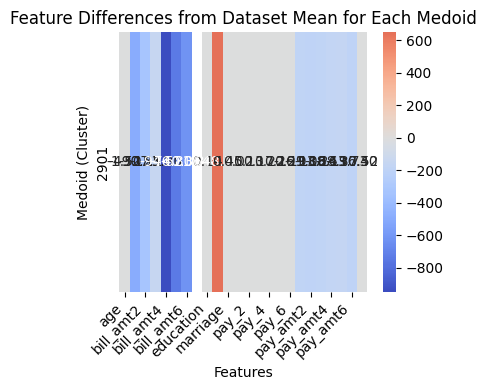

In [60]:

plt.figure(figsize=(4, 4))
sns.heatmap(feature_comparisons, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title('Feature Differences from Dataset Mean for Each Medoid')
plt.ylabel('Medoid (Cluster)')
plt.xlabel('Features')
plt.xticks(rotation=45, ha="right")  
plt.tight_layout()
plt.show()


### Feature Engineering

In [61]:
train_df, numerical_columns, categorical_columns = apply_transformations(train_df, numerical_columns, categorical_columns)
test_df, numerical_columns, categorical_columns = apply_transformations(test_df, numerical_columns, categorical_columns)


In [62]:

train_df, test_df = train_df.align(test_df, join='outer', axis=1, fill_value=0)


In [63]:
train_df.columns

Index(['age', 'age_group', 'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4',
       'bill_amt5', 'bill_amt6', 'bill_pay_ratio', 'customer_id',
       'default_oct', 'edu_marriage_interaction', 'education', 'limit_bal',
       'marriage', 'pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6',
       'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6',
       'pay_bill_ratio_1', 'pay_bill_ratio_2', 'pay_bill_ratio_3',
       'pay_bill_ratio_4', 'pay_bill_ratio_5', 'pay_bill_ratio_6', 'sex',
       'total_bill_amt', 'total_pay_amt'],
      dtype='object')

In [64]:
X = train_df.drop(columns=['default_oct', 'customer_id'])
y = train_df['default_oct'].map({'yes': 1, 'no': 0}) 

In [65]:
# Tune each classifier
best_logistic_fe_optuna = tune_classifier(
    LogisticRegression(),  # classifier instance
    param_grid_logistic,   # parameter distribution
    X,                     # features
    y,                     # target variable
    numerical_columns,     # list of names of numerical columns
    categorical_columns,   # list of names of categorical columns
    method='optuna',  # method of hyperparameter optimization
    n_trials=25,            # number of iterations/trials
    cv=cv
)
dump(best_logistic_fe_optuna, '../models/best_logistic_fe_optuna.joblib')

[I 2024-03-29 23:52:15,165] A new study created in memory with name: no-name-484157e9-f497-4a62-9faa-380c86401af7
[I 2024-03-29 23:52:21,052] Trial 0 finished with value: 0.5685395356591277 and parameters: {'C': 0.11829276390120953, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 0 with value: 0.5685395356591277.
/Users/ganeshmorye/miniconda3/envs/arene-woven/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ganeshmorye/miniconda3/envs/arene-woven/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ganeshmorye/miniconda3/envs/arene-woven/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ganeshmorye/miniconda3/envs/arene-wove

['../models/best_logistic_fe_optuna.joblib']

In [66]:
best_rf_fe_optuna = tune_classifier(RandomForestClassifier(), 
    param_grid_rf,
    X,                     # features
    y,                     # target variable
    numerical_columns,     # list of names of numerical columns
    categorical_columns,   # list of names of categorical columns
    method='optuna',  # method of hyperparameter optimization
    n_trials=25,            # number of iterations/trials
    cv=cv
)
dump(best_rf_fe_optuna, '../models/best_rf_fe_optuna.joblib')


[I 2024-03-29 23:54:35,518] A new study created in memory with name: no-name-faa2a426-9302-4f43-8119-f738704f1683
[I 2024-03-29 23:54:44,851] Trial 0 finished with value: 0.5632265166321341 and parameters: {'n_estimators': 200, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.5632265166321341.
[I 2024-03-29 23:54:55,608] Trial 1 finished with value: 0.5192786345922736 and parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.5192786345922736.
[I 2024-03-29 23:55:05,008] Trial 2 finished with value: 0.5631322327713021 and parameters: {'n_estimators': 200, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.5192786345922736.
[I 2024-03-29 23:55:27,363] Trial 3 finished with value: 0.4845790389647366 and parameters: {'n_estimators': 100, 'max_depth': 30, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 3 with value:

['../models/best_rf_fe_optuna.joblib']

In [67]:
best_gbm_fe_optuna = tune_classifier(GradientBoostingClassifier(), 
    param_grid_gbm,     
    X,                     # features
    y,                     # target variable
    numerical_columns,     # list of names of numerical columns
    categorical_columns,   # list of names of categorical columns
    method='optuna',  # method of hyperparameter optimization
    n_trials=25,            # number of iterations/trials
    cv=cv
)

dump(best_gbm_fe_optuna, '../models/best_gbm_fe_optuna.joblib')


[I 2024-03-30 00:27:52,241] A new study created in memory with name: no-name-ed04355b-dd35-4853-8caf-b8ca5dbe736c
[I 2024-03-30 00:29:25,902] Trial 0 finished with value: 0.6656165861568389 and parameters: {'n_estimators': 100, 'learning_rate': 0.001, 'max_depth': 9, 'subsample': 0.75}. Best is trial 0 with value: 0.6656165861568389.
[I 2024-03-30 00:30:10,464] Trial 1 finished with value: 0.45802726564482665 and parameters: {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 5, 'subsample': 0.75}. Best is trial 1 with value: 0.45802726564482665.
[I 2024-03-30 00:32:19,285] Trial 2 finished with value: 0.5048105164022482 and parameters: {'n_estimators': 300, 'learning_rate': 0.01, 'max_depth': 5, 'subsample': 0.75}. Best is trial 1 with value: 0.45802726564482665.
[I 2024-03-30 00:32:39,288] Trial 3 finished with value: 0.6742491865396673 and parameters: {'n_estimators': 100, 'learning_rate': 0.001, 'max_depth': 3, 'subsample': 0.5}. Best is trial 1 with value: 0.45802726564482665

['../models/best_gbm_fe_optuna.joblib']

In [68]:
best_logistic_fe_optuna = load('../models/best_logistic_fe_optuna.joblib')
best_rf_fe_optuna = load('../models/best_rf_fe_optuna.joblib')
best_gbm_fe_optuna = load('../models/best_gbm_fe_optuna.joblib')

In [69]:
# Train and evaluate ensemble models with the best classifiers
voting_clf_fe_optuna, stacking_clf_fe_optuna = train_and_evaluate_ensemble(X, y, [best_logistic_fe_optuna, best_rf_fe_optuna, best_gbm_fe_optuna])

Voting Classifier Log Loss: 0.4767684455112017
Stacking Classifier Log Loss: 0.4326300089785159


In [70]:
# Fit the chosen pipeline on the entire dataset
voting_clf_fe_optuna.fit(X, y)

create_and_save_submission(voting_clf_fe_optuna, test_df, 'customer_id', 'voting_ensemble_optuna_fe_predictions.csv')

Submission file saved to voting_ensemble_optuna_fe_predictions.csv


In [71]:
# Fit the chosen pipeline on the entire dataset
stacking_clf_fe_optuna.fit(X, y)

create_and_save_submission(stacking_clf_fe_optuna, test_df, 'customer_id', 'stacking_ensemble_optuna_fe_predictions.csv')

Submission file saved to stacking_ensemble_optuna_fe_predictions.csv


## Future Work

**Customer Segmentation**

- **Demographic Segmentation:** 
- **Geographic Segmentation:** 
- **Psychographic Segmentation:** 
- **Behavioral Segmentation:** 

**Feature Engineering**

- **Polynomial Features**
- **Feature Selection**

**Further Evaluation**

- **PR-AUC and Precision-Recall and F1-Score Analysis**
- **Threshold Tuning using Cost-Benefit Analysis**
